# 1. Loading Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Input,Dropout,Flatten,concatenate,AveragePooling2D,add,concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Model,Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
import warnings
#surpressing warnings
warnings.filterwarnings(action = 'ignore')

# 2. Loading Data

<h3> Loading Train Data </h3>

A simple iteration through the file system using the specified link, to load the ".jpg" files into 128*128 arrays (the training data) and add their correspond labels to our labels to a different array (the labels)

In [3]:
p = Path('./brain-tumor-classification-mri/Training')
dirs = p.glob('*') 
labels = []
image_data = []
label_dict = {'glioma_tumor':0 , 'meningioma_tumor':1,'no_tumor':2,'pituitary_tumor':3}
for folder in dirs:
    label = str(folder).split('\\')[-1] #do note that this must be changed to forward slash in unix systems 
    print(label)#making sure the labels we are getting are the same as the names of the folders in the training dataset
    for image_path in folder.glob('*.jpg'):
        img = image.load_img(image_path,target_size = (128,128))
        img_array =image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])
x_train = np.array(image_data)
y_train = np.array(labels)


glioma_tumor
meningioma_tumor
no_tumor
pituitary_tumor


<h3> Loading test data </h3>

Same as the section above but instead of training data we have test data 

In [4]:
p = Path('./brain-tumor-classification-mri/Testing')
dirs = p.glob('*')
labels = []
image_data = []
label_dict = {'glioma_tumor':0 , 'meningioma_tumor':1,'no_tumor':2,'pituitary_tumor':3}
for folder in dirs:
    label = str(folder).split('\\')[-1]# same remark reguarding the unix systems
    print(label)
    for image_path in folder.glob('*.jpg'):
        img = image.load_img(image_path,target_size = (128,128))
        img_array =image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])
x_test = np.array(image_data)
y_test = np.array(labels)

glioma_tumor
meningioma_tumor
no_tumor
pituitary_tumor


# 3. Visualizing Data:

Now I'm going to visualize 5 images, one of each kind, to get a general grasp of how each tumor type / a healthy brain looks like in MRI scans
Do note that the relationship (label : name) was defined above in the following dictionary:
{'glioma_tumor':0, 'meningioma_tumor':1,'no_tumor':2,'pituitary_tumor':3}

[0, 1, 2, 3, 4, 827, 828, 829, 830, 831, 1649, 1650, 1651, 1652, 1653, 2044, 2045, 2046, 2047, 2048]
[[   0  827 1649 2044]
 [   1  828 1650 2045]
 [   2  829 1651 2046]
 [   3  830 1652 2047]
 [   4  831 1653 2048]]


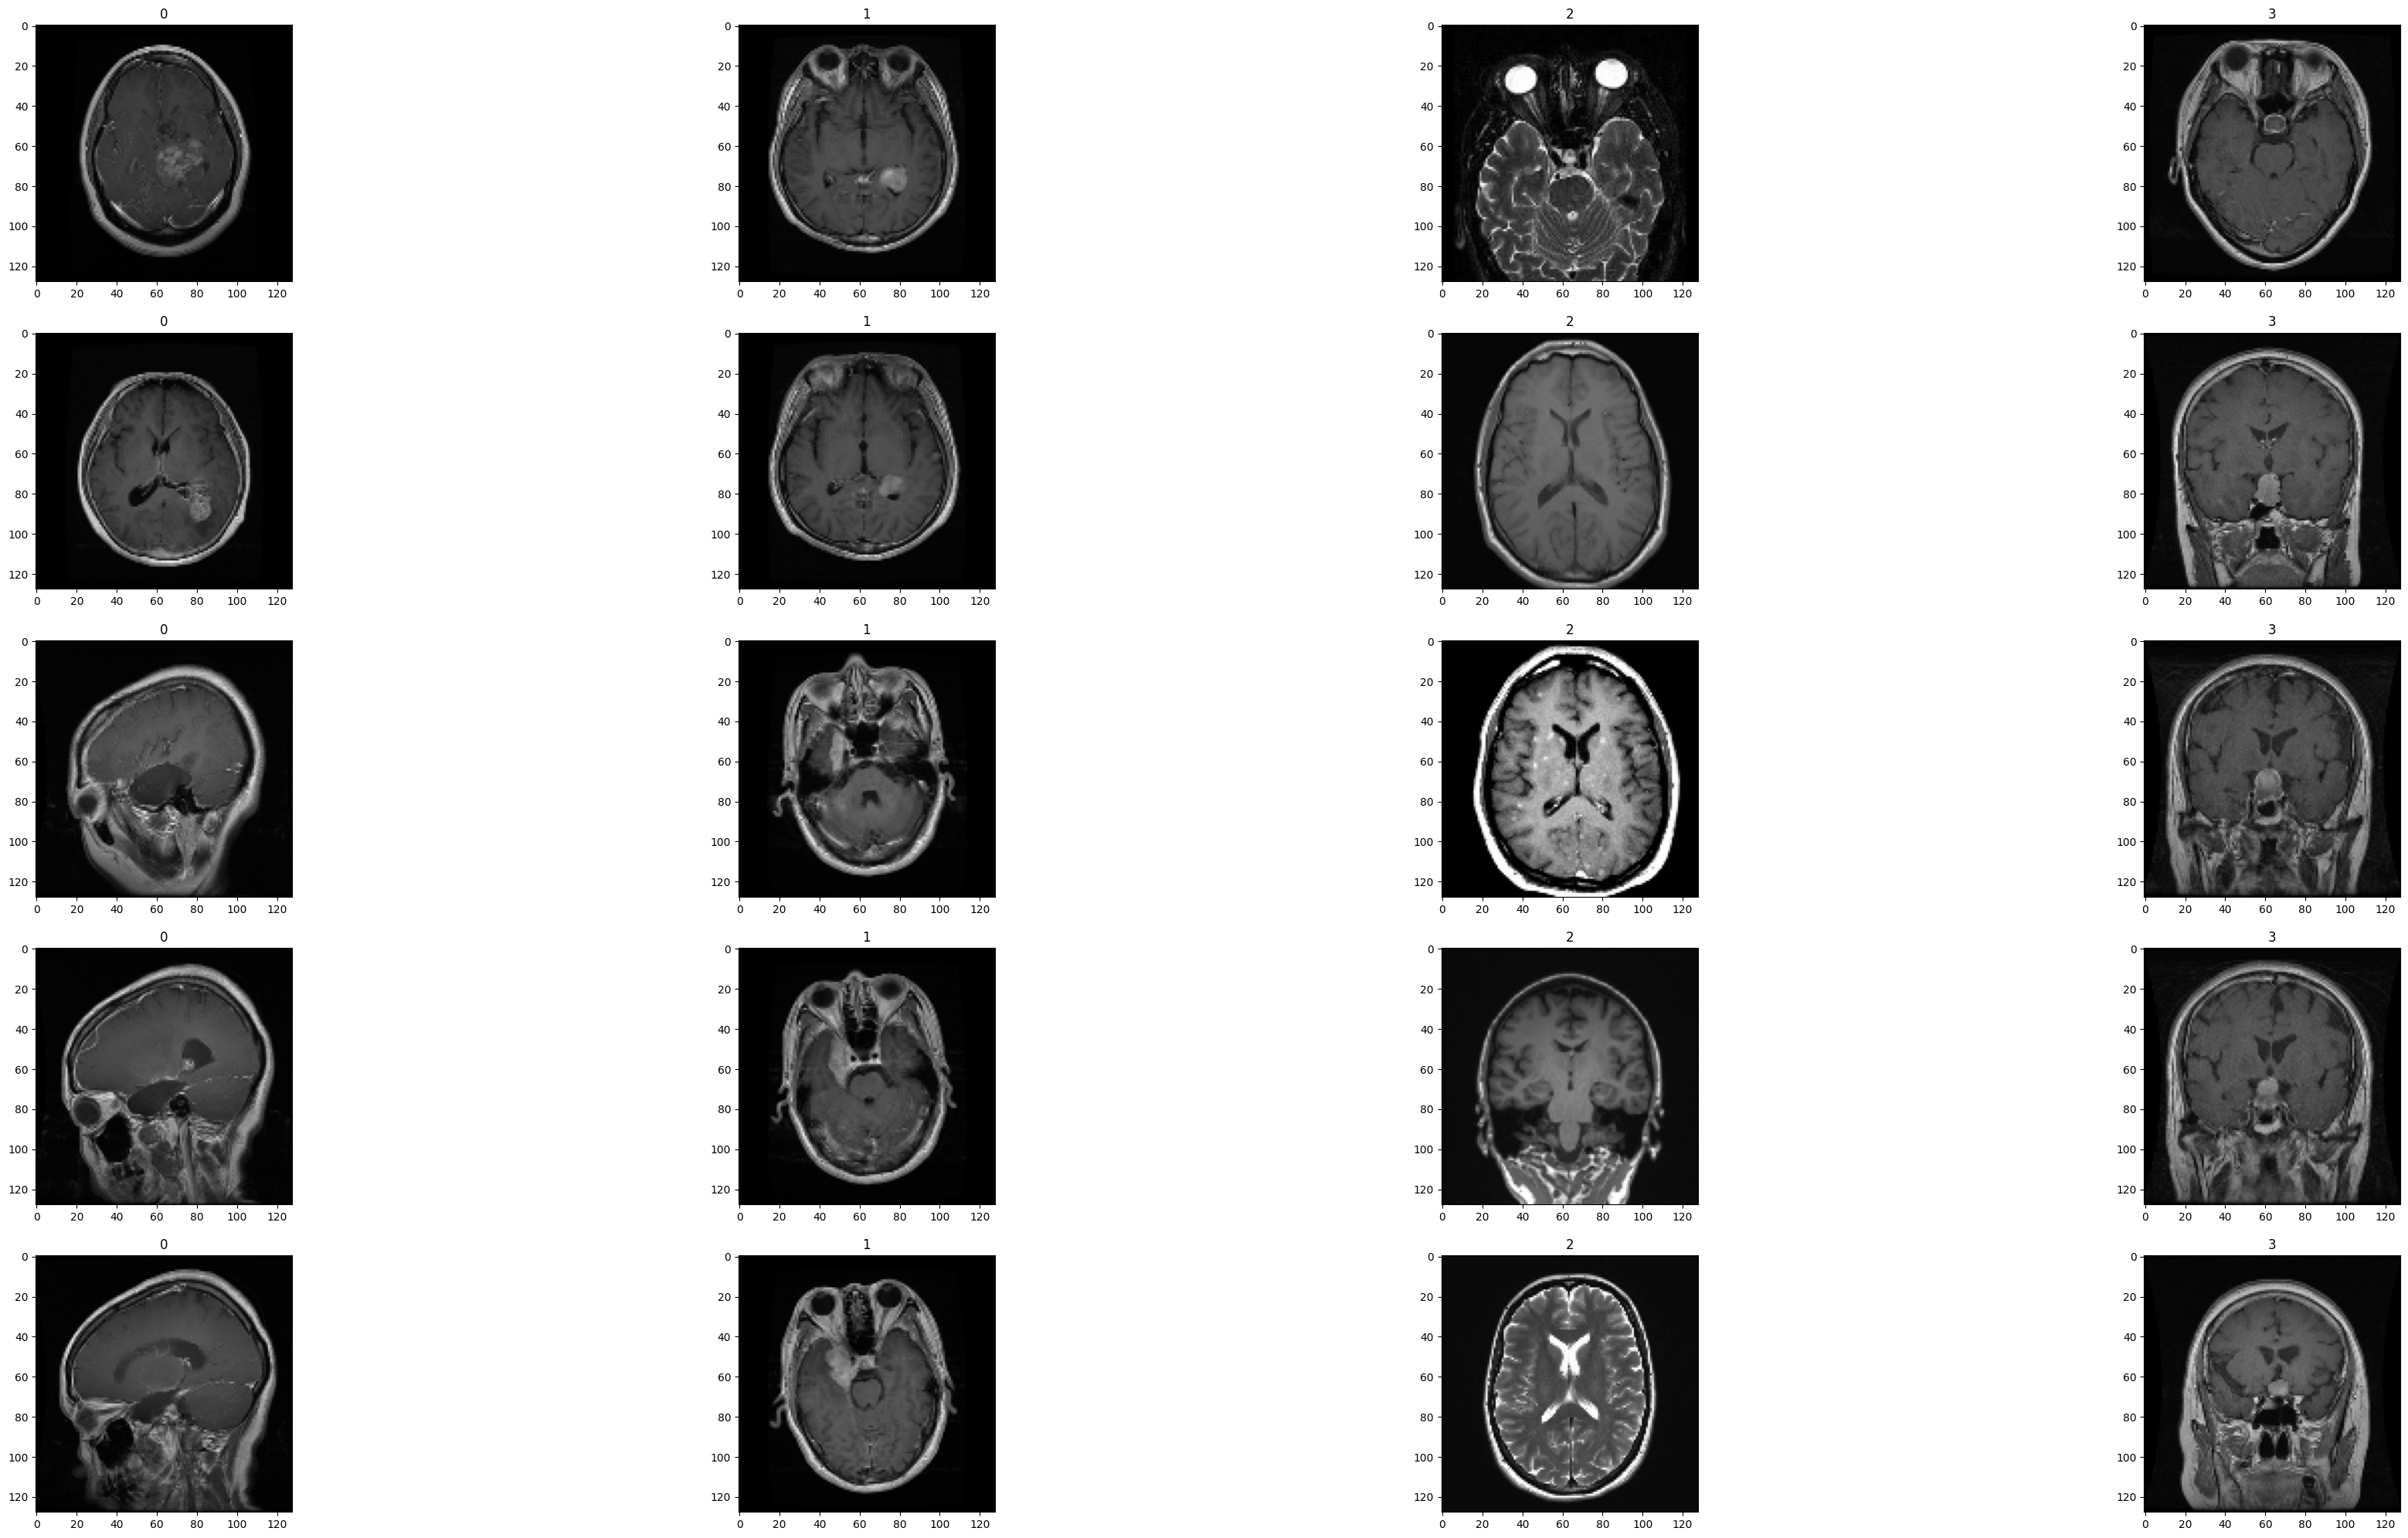

In [5]:
fig,ax = plt.subplots(5,4,figsize = (45,25))
#each column represents 5 images of the same data type :glioma, no tumor ,meningioma or pituitary 
#lets get the 5 first of each kind 

count=0
current = 0

indexes=[]
for i in range(len(y_train)):
    if (y_train[i]==current):
        if(count<5):
            indexes.append(i)
            count+=1
    else:
        count=0
        current=y_train[i]

print(indexes)

x = np.reshape(indexes, (4, 5)).T


print(x)

for i in range(5):
    for j in range(4):
        ax[i][j].imshow(x_train[x[i][j]]/255.0)
        ax[i][j].set_title(y_train[x[i][j]])




# 4. Pre Processing and splitting

Normalizing data

In [6]:
x_train = x_train/255.0
x_test = x_test/255.0 

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(x_train,y_train,test_size = 0.18,random_state = 42)

# refere to the following link for more information
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [8]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# 5. Function for visualizing model performance

In [9]:
# function for visualzing model performance
def plot_function(history):
    fig,ax = plt.subplots(1,2,figsize = (25,5))
    ax[0].plot(history.history['loss'],color = 'red',label = 'train_loss')
    ax[0].set_title('Loss and val_loss')
    ax[0].plot(history.history['val_loss'],color = 'green',label = 'val_loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'],color = 'orange',label = 'train_accuracy')
    ax[1].set_title('accuracy and val_accuracy')
    ax[1].plot(history.history['val_accuracy'],color = 'black',label = 'val_accuarcy')
    ax[1].legend()

# 6. Neural Networks

In [10]:
def model1(input_shape):#5 convolutions
   inputs = Input(shape = input_shape)
   
   x = Conv2D(256,2,activation = 'relu',strides = 2,padding = 'same')(inputs)
   x = MaxPooling2D()(x)
   x = Dropout(0.20)(x)
   
   x = Conv2D(128,3,activation = 'relu',strides = 2,padding = 'same')(x)
   x = BatchNormalization()(x)
   x = MaxPooling2D()(x)
   x = Dropout(0.20)(x)
   
   x = Conv2D(512,3,activation = 'relu',strides = 1,padding = 'same')(x)
   x = BatchNormalization()(x)
   x = MaxPooling2D()(x)
   x = Dropout(0.20)(x)
   
   x = Conv2D(1024,2,activation = 'relu',strides = 3,padding = 'same')(x)
   x = BatchNormalization()(x)
   x = MaxPooling2D()(x)
   x = Dropout(0.22)(x)
   
   x = Conv2D(16,2,activation = 'relu',strides = 2,padding = 'same')(x)
   x = BatchNormalization()(x)
   
   
   x = Flatten()(x)
   x = Dense(16,activation = 'relu')(x)
   x = Dense(16,activation = 'relu')(x)
   x = Dense(16,activation = 'relu')(x)
   x = Dense(16,activation = 'relu')(x)
   x = Dense(16,activation = 'relu')(x)
   
   outputs = Dense(4,activation = 'softmax')(x)
   model = Model(inputs,outputs)
   
   return model
   
def model2(input_shape):# a single convolution network
   inputs = Input(shape = input_shape)
   x = Conv2D(256,2,activation = 'relu',strides = 2,padding = 'same')(inputs)
   x = MaxPooling2D()(x)
   x = Dropout(0.20)(x)    
   x = Flatten()(x)
   x = Dense(16,activation = 'relu')(x)
   x = Dense(16,activation = 'relu')(x)
   outputs = Dense(4,activation = 'softmax')(x)
   model = Model(inputs,outputs)
   return model    
    
    
    
    

In [11]:
clf2 = model2(input_shape=(128,128,3))
clf2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 256)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 16)                4194320   
                                                             

In [25]:
clf1 = model1(input_shape = (128,128,3))
clf1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 256)       3328      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 32, 32, 256)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_12 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                          

In [13]:
plot_model(clf2)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
plot_model(clf1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
#model2
checkpoint = ModelCheckpoint("./model2.h5",monitor = 'val_acc',verbose = 1,save_best_only = True)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.08,patience = 3)
callback = [checkpoint,reduce_learning_rate]
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01,weight_decay = 6e-5)
clf2.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [26]:
#model 1
checkpoint = ModelCheckpoint("./model.h5",monitor = 'val_acc',verbose = 1,save_best_only = True)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.08,patience = 3)
callback = [checkpoint,reduce_learning_rate]
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01,weight_decay = 6e-5)
clf1.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

# 7. training
**I will first try the training with a low amount number of epoch to see which configuration works best**

First we will start with 10 epochs per configuration
After that we will do a full training with 200 epochs for the configuration with the highest accuracy
This approach may not be optimal as a question that comes to mind are configurations capable of exceeding other configurations in accuracy on higher epochs numbers while they have lower accuracies on lower epochs numbers 



In [28]:
history1 = clf1.fit(X_train,Y_train,batch_size = 128,epochs = 10,validation_data = (X_test,Y_test)) 


Epoch 1/10
19/19 [==============================] - 61s 3s/step - loss: 1.0398 - accuracy: 0.5504 - val_loss: 296.7579 - val_accuracy: 0.1257
Epoch 2/10
19/19 [==============================] - 53s 3s/step - loss: 0.7285 - accuracy: 0.6949 - val_loss: 92.6885 - val_accuracy: 0.1257
Epoch 3/10
19/19 [==============================] - 54s 3s/step - loss: 0.6341 - accuracy: 0.7301 - val_loss: 38.7408 - val_accuracy: 0.1257
Epoch 4/10
19/19 [==============================] - 55s 3s/step - loss: 0.5641 - accuracy: 0.7697 - val_loss: 24.6226 - val_accuracy: 0.1257
Epoch 5/10
19/19 [==============================] - 51s 3s/step - loss: 0.5310 - accuracy: 0.7807 - val_loss: 11.7562 - val_accuracy: 0.1257
Epoch 6/10
19/19 [==============================] - 52s 3s/step - loss: 0.5104 - accuracy: 0.8045 - val_loss: 11.1773 - val_accuracy: 0.1257
Epoch 7/10
19/19 [==============================] - 54s 3s/step - loss: 0.4513 - accuracy: 0.8164 - val_loss: 3.0672 - val_accuracy: 0.2534
Epoch 8/10
19

In [29]:
history2=clf2.fit(X_train,Y_train,batch_size = 128,epochs = 10,validation_data = (X_test,Y_test))

Epoch 1/10
19/19 [==============================] - 31s 2s/step - loss: 1.3499 - accuracy: 0.2949 - val_loss: 1.3417 - val_accuracy: 0.2573
Epoch 2/10
19/19 [==============================] - 31s 2s/step - loss: 1.3505 - accuracy: 0.2949 - val_loss: 1.3420 - val_accuracy: 0.2573
Epoch 3/10
19/19 [==============================] - 31s 2s/step - loss: 1.3503 - accuracy: 0.2949 - val_loss: 1.3411 - val_accuracy: 0.2573
Epoch 4/10
19/19 [==============================] - 31s 2s/step - loss: 1.3499 - accuracy: 0.2949 - val_loss: 1.3411 - val_accuracy: 0.2573
Epoch 5/10
19/19 [==============================] - 32s 2s/step - loss: 1.3503 - accuracy: 0.2949 - val_loss: 1.3416 - val_accuracy: 0.2573
Epoch 6/10
19/19 [==============================] - 29s 2s/step - loss: 1.3504 - accuracy: 0.2949 - val_loss: 1.3405 - val_accuracy: 0.2573
Epoch 7/10
19/19 [==============================] - 31s 2s/step - loss: 1.3499 - accuracy: 0.2949 - val_loss: 1.3418 - val_accuracy: 0.2573
Epoch 8/10
19/19 [==

In [30]:
clf2.evaluate(X_test,Y_test)

17/17 [==============================] - 2s 94ms/step - loss: 1.3414 - accuracy: 0.2573


[1.341361165046692, 0.25725337862968445]

In [31]:
clf1.evaluate(X_test,Y_test)

17/17 [==============================] - 2s 137ms/step - loss: 3.7195 - accuracy: 0.2515


[3.7195165157318115, 0.25145068764686584]

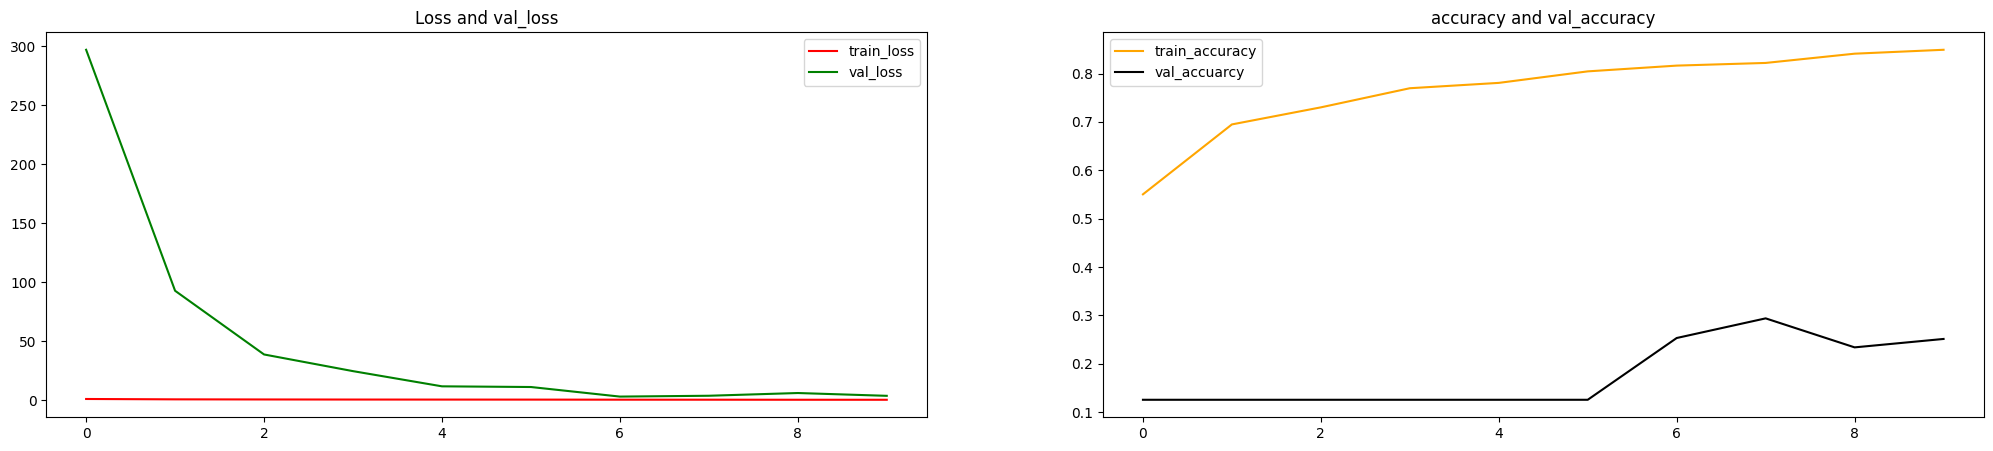

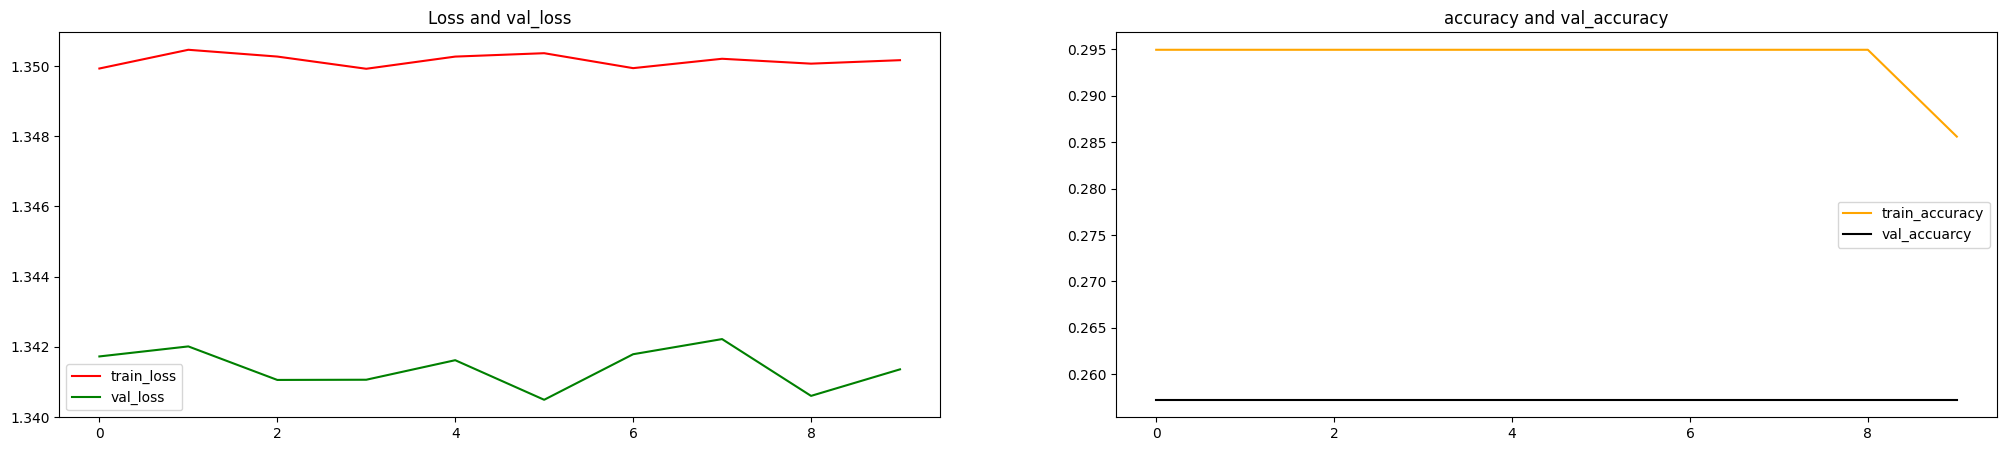

In [33]:
plot_function(history1)
plot_function(history2)

# 7. Making Predictions

In [35]:
prediction = clf1.predict(x_test)
prediction = clf2.predict(x_test)

13/13 [==============================] - 1s 97ms/step


In [36]:
prediction = np.argmax(prediction,axis = 1)

In [37]:
prediction

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

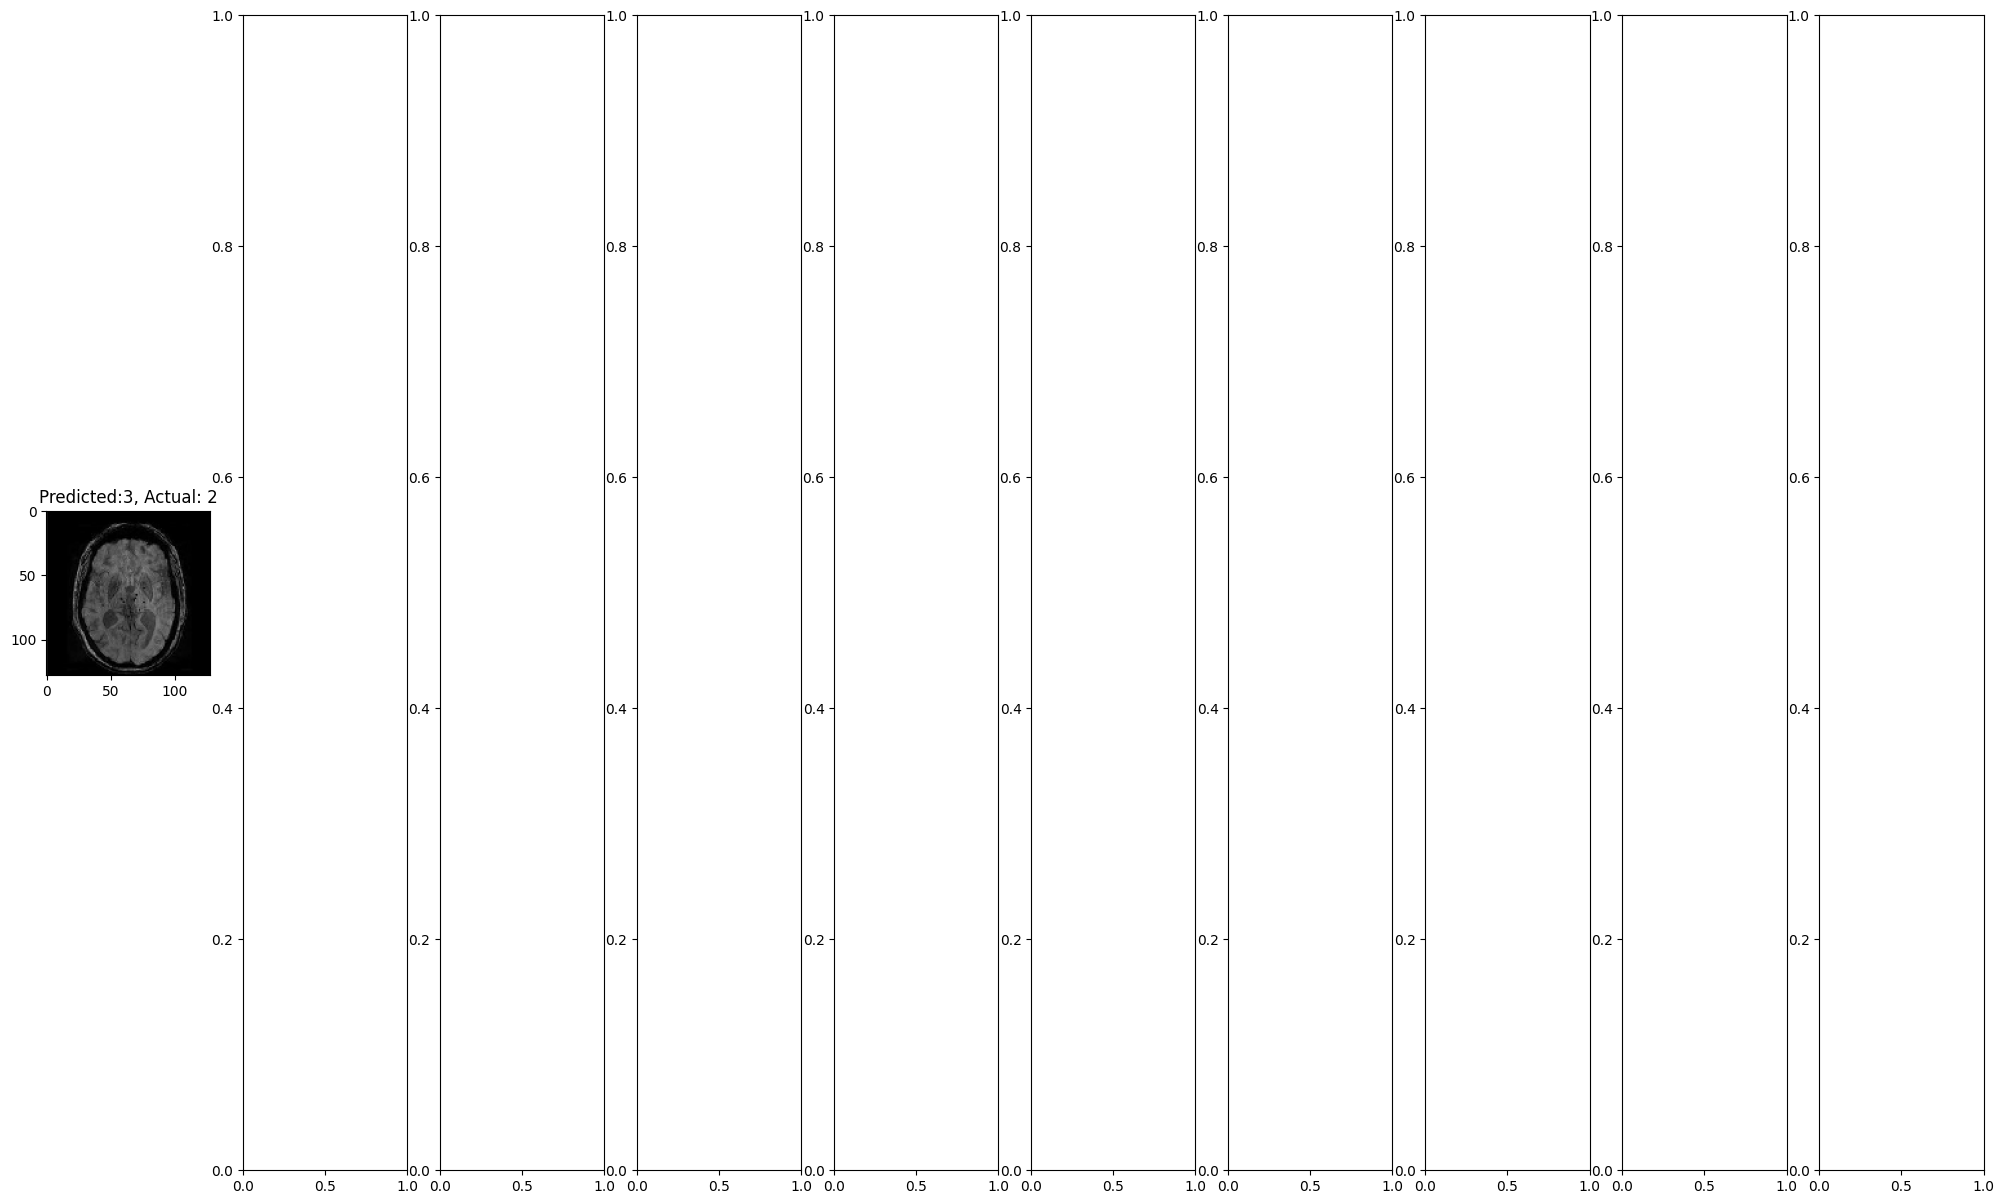

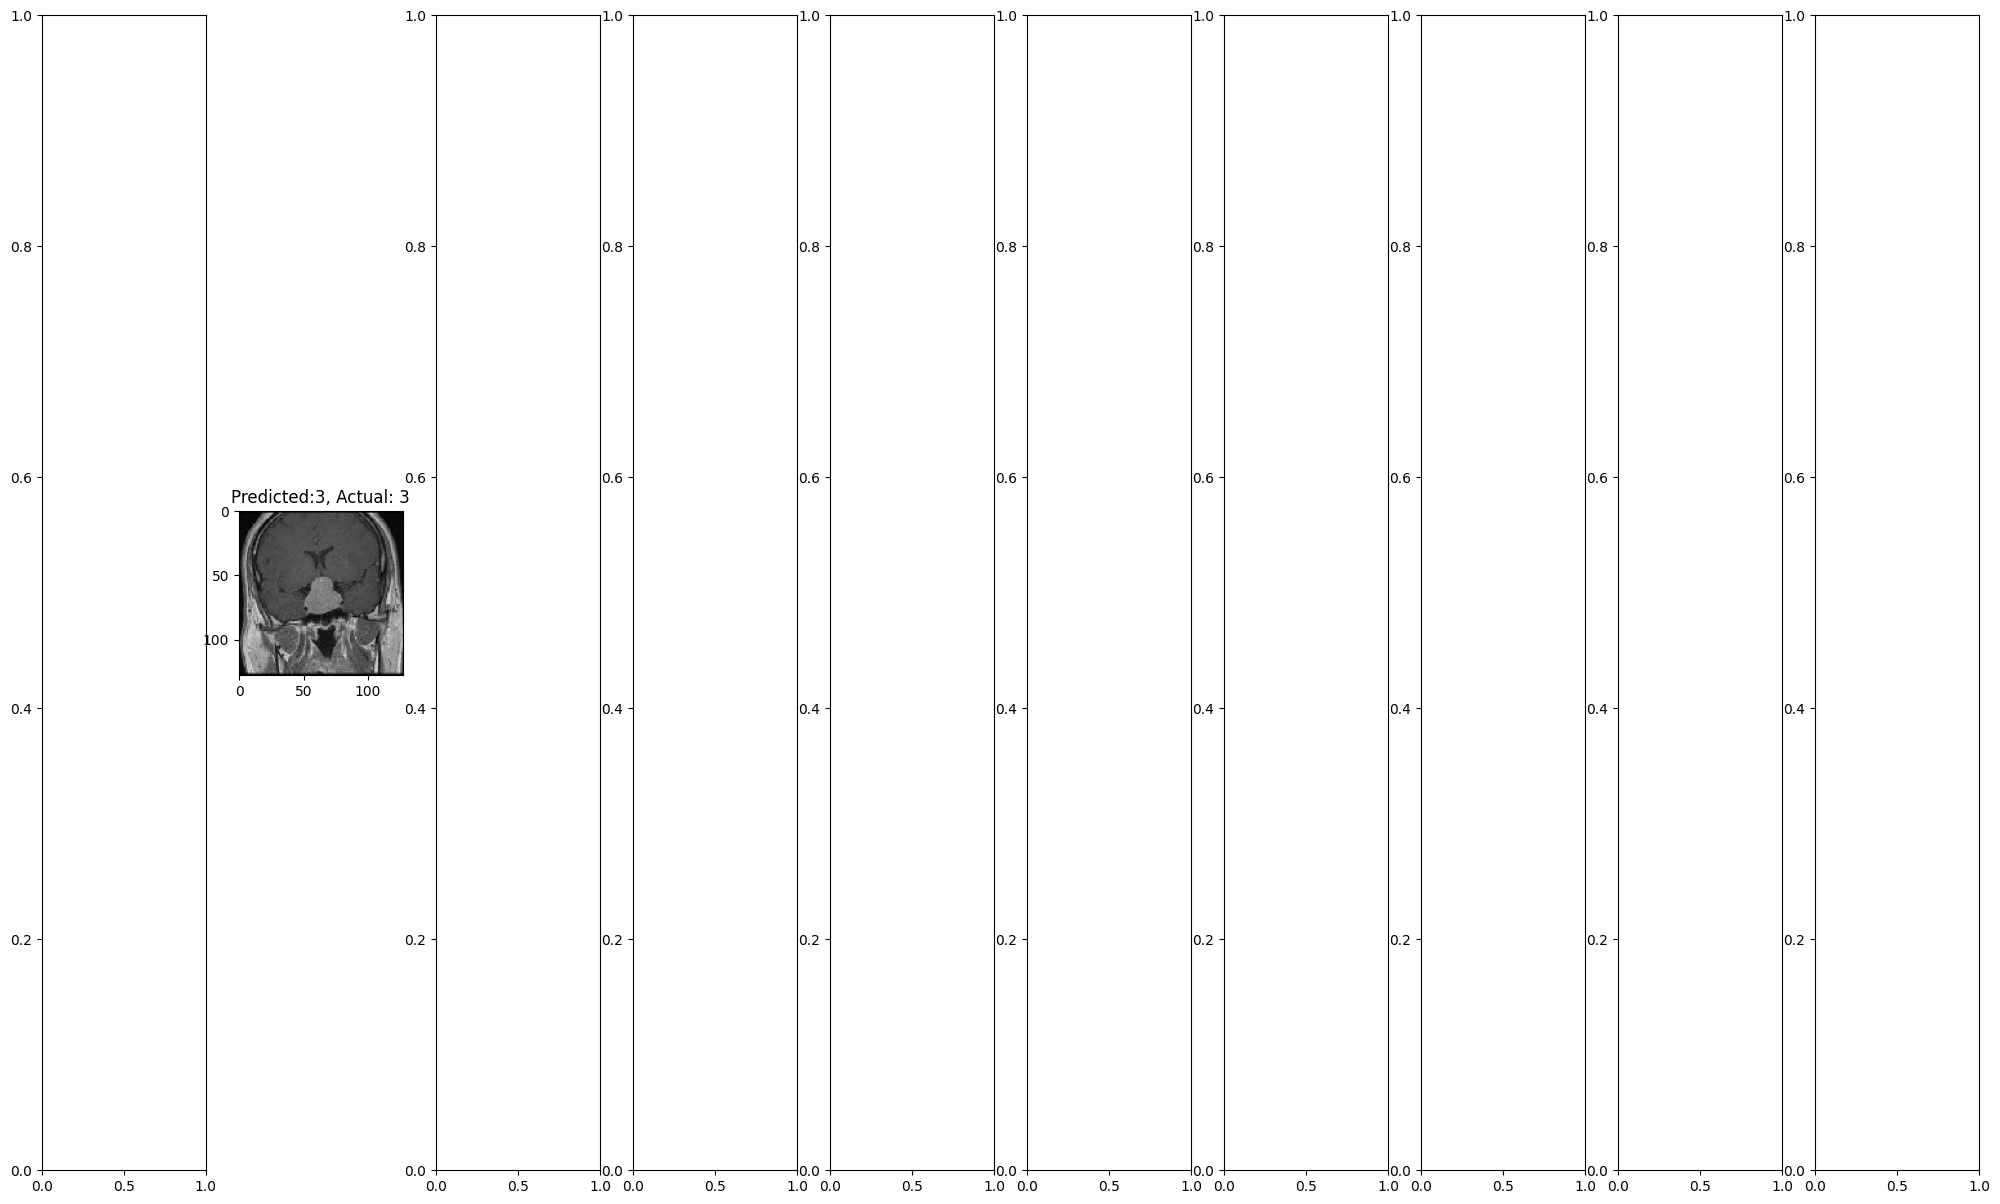

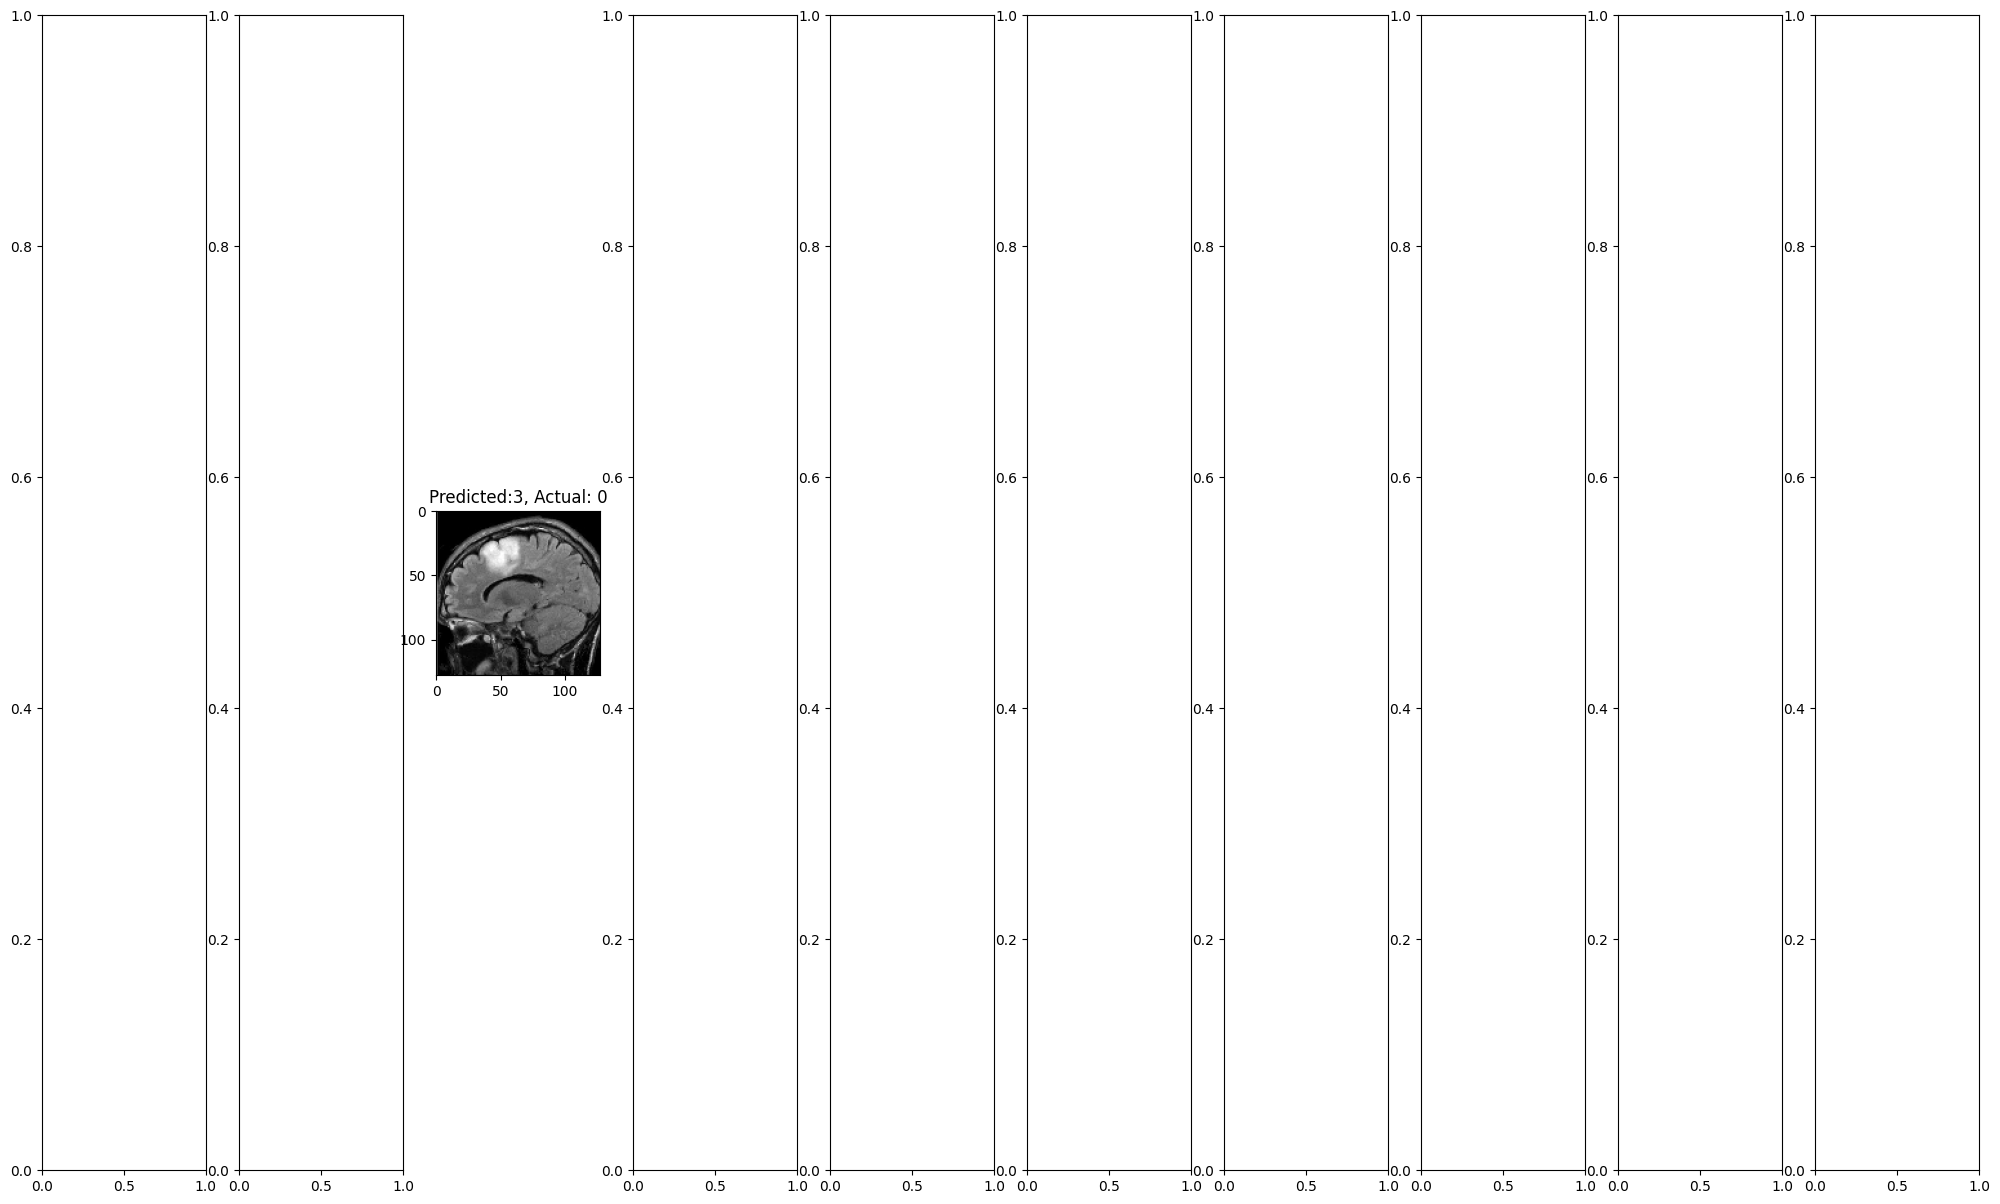

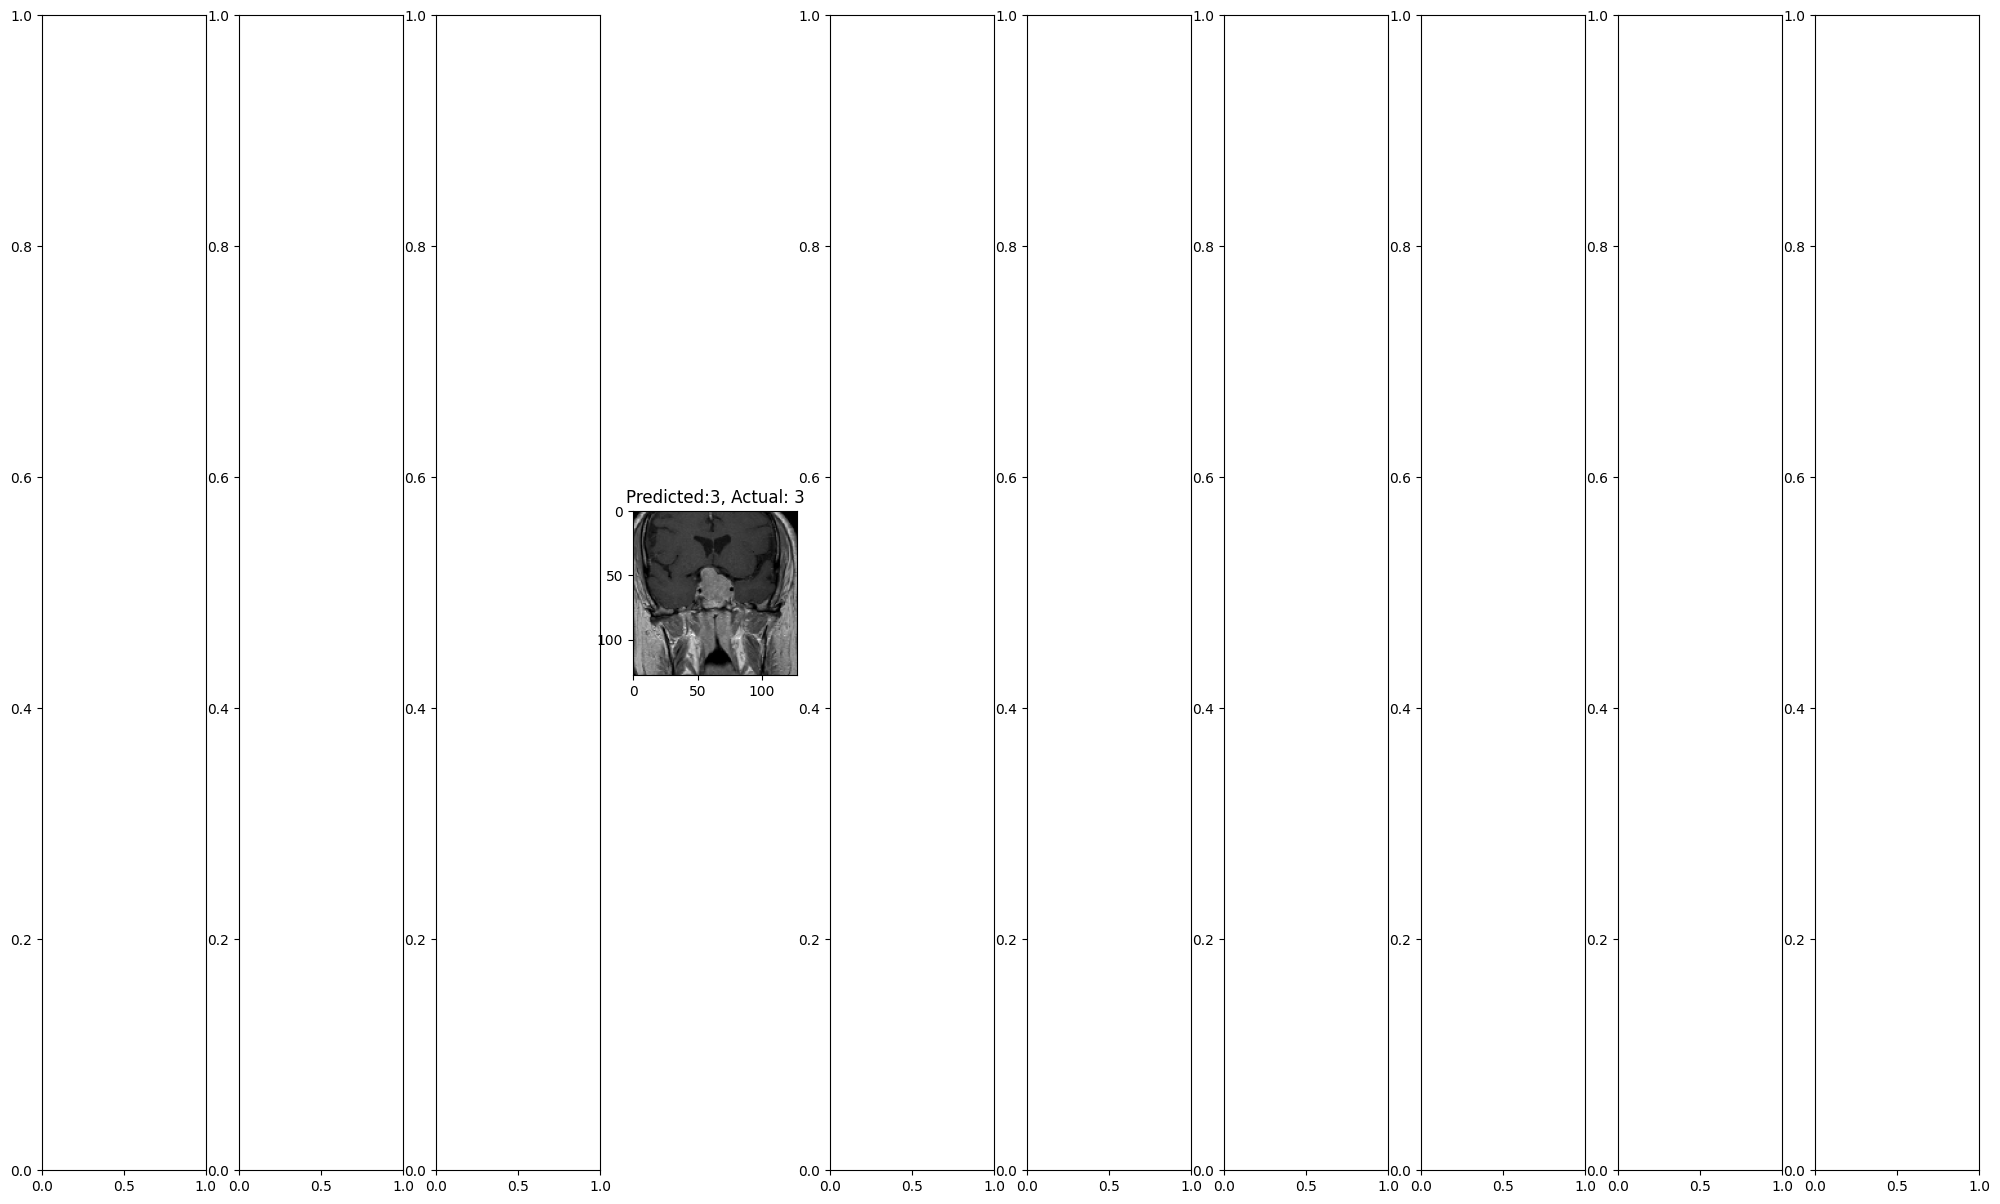

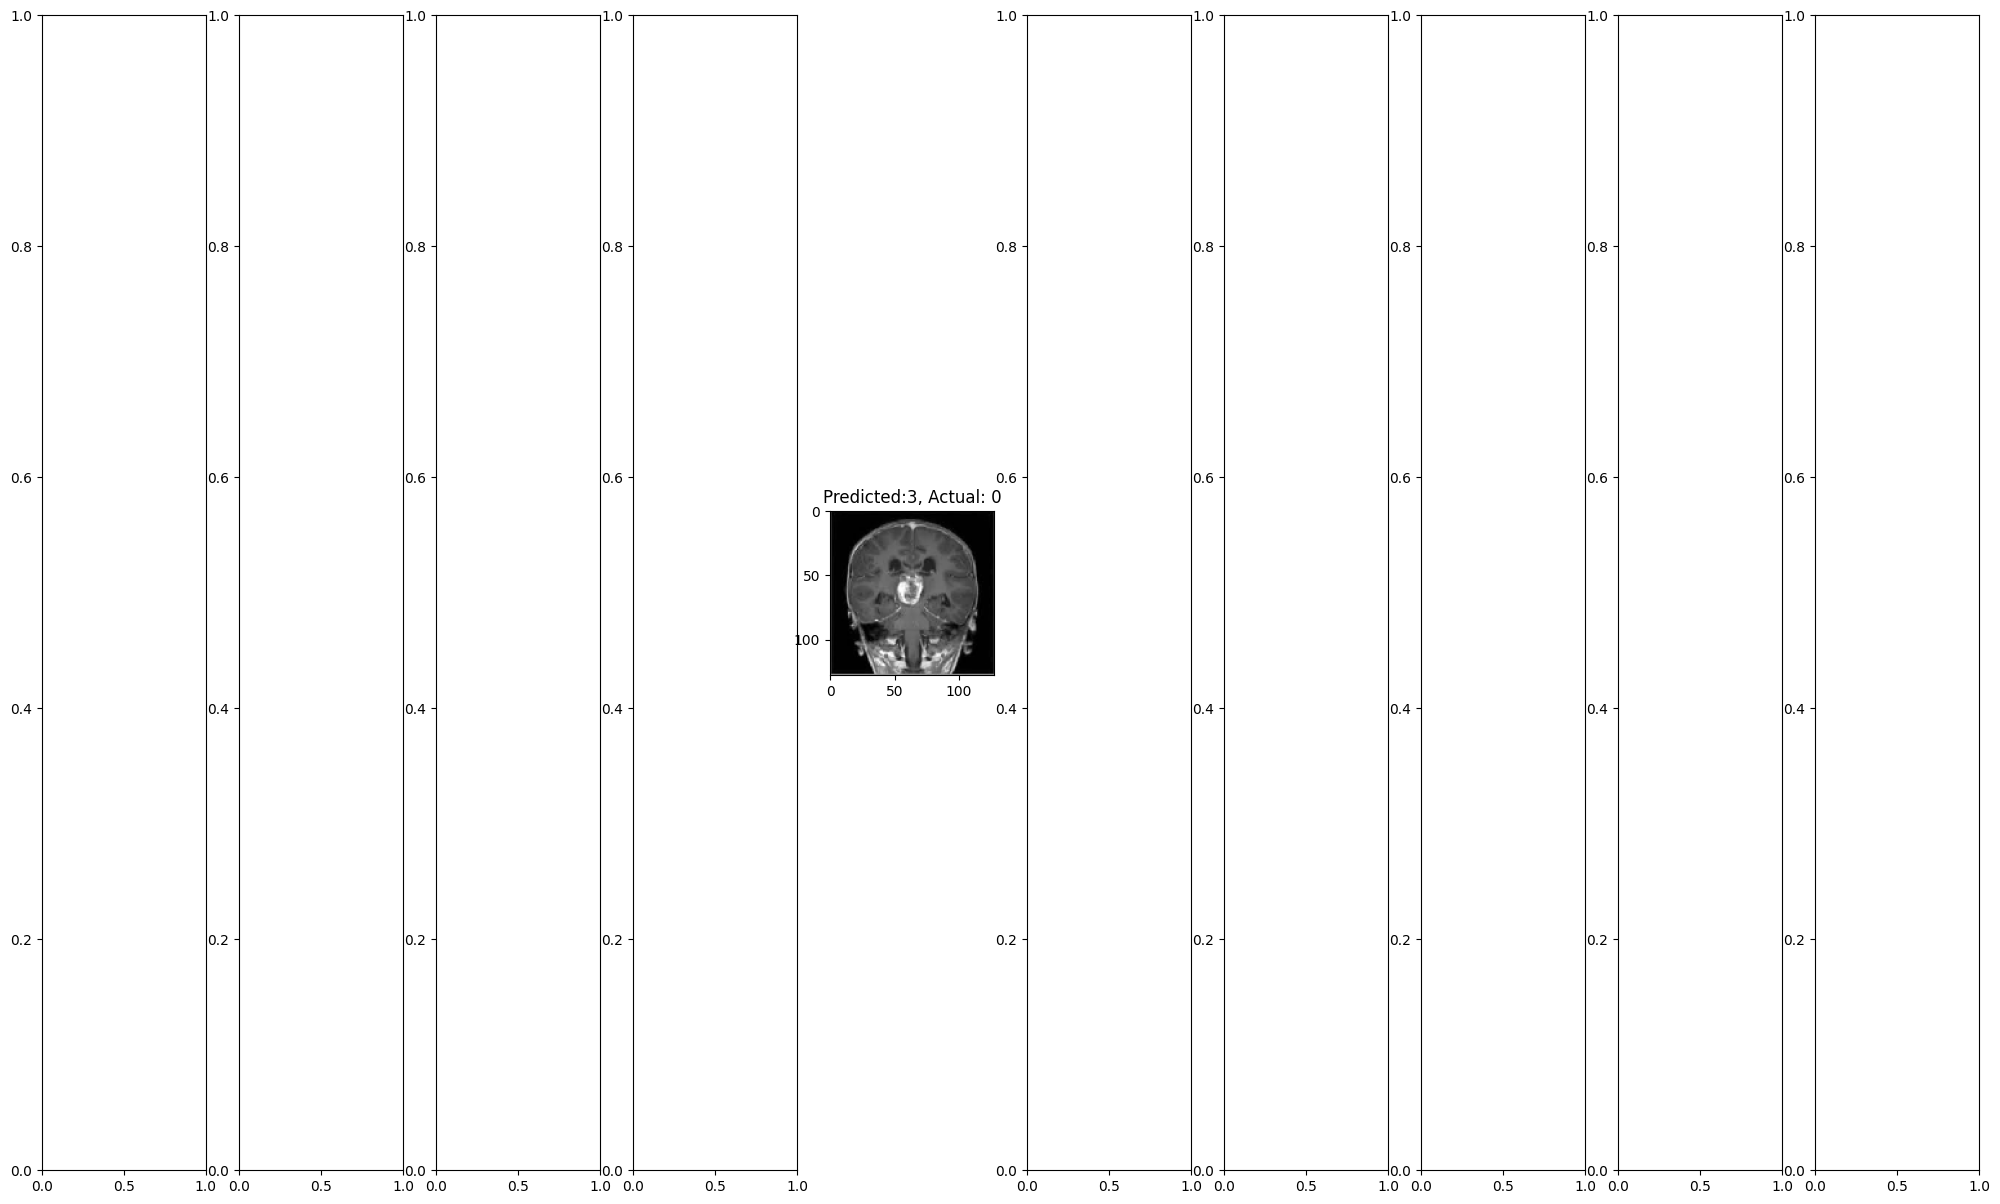

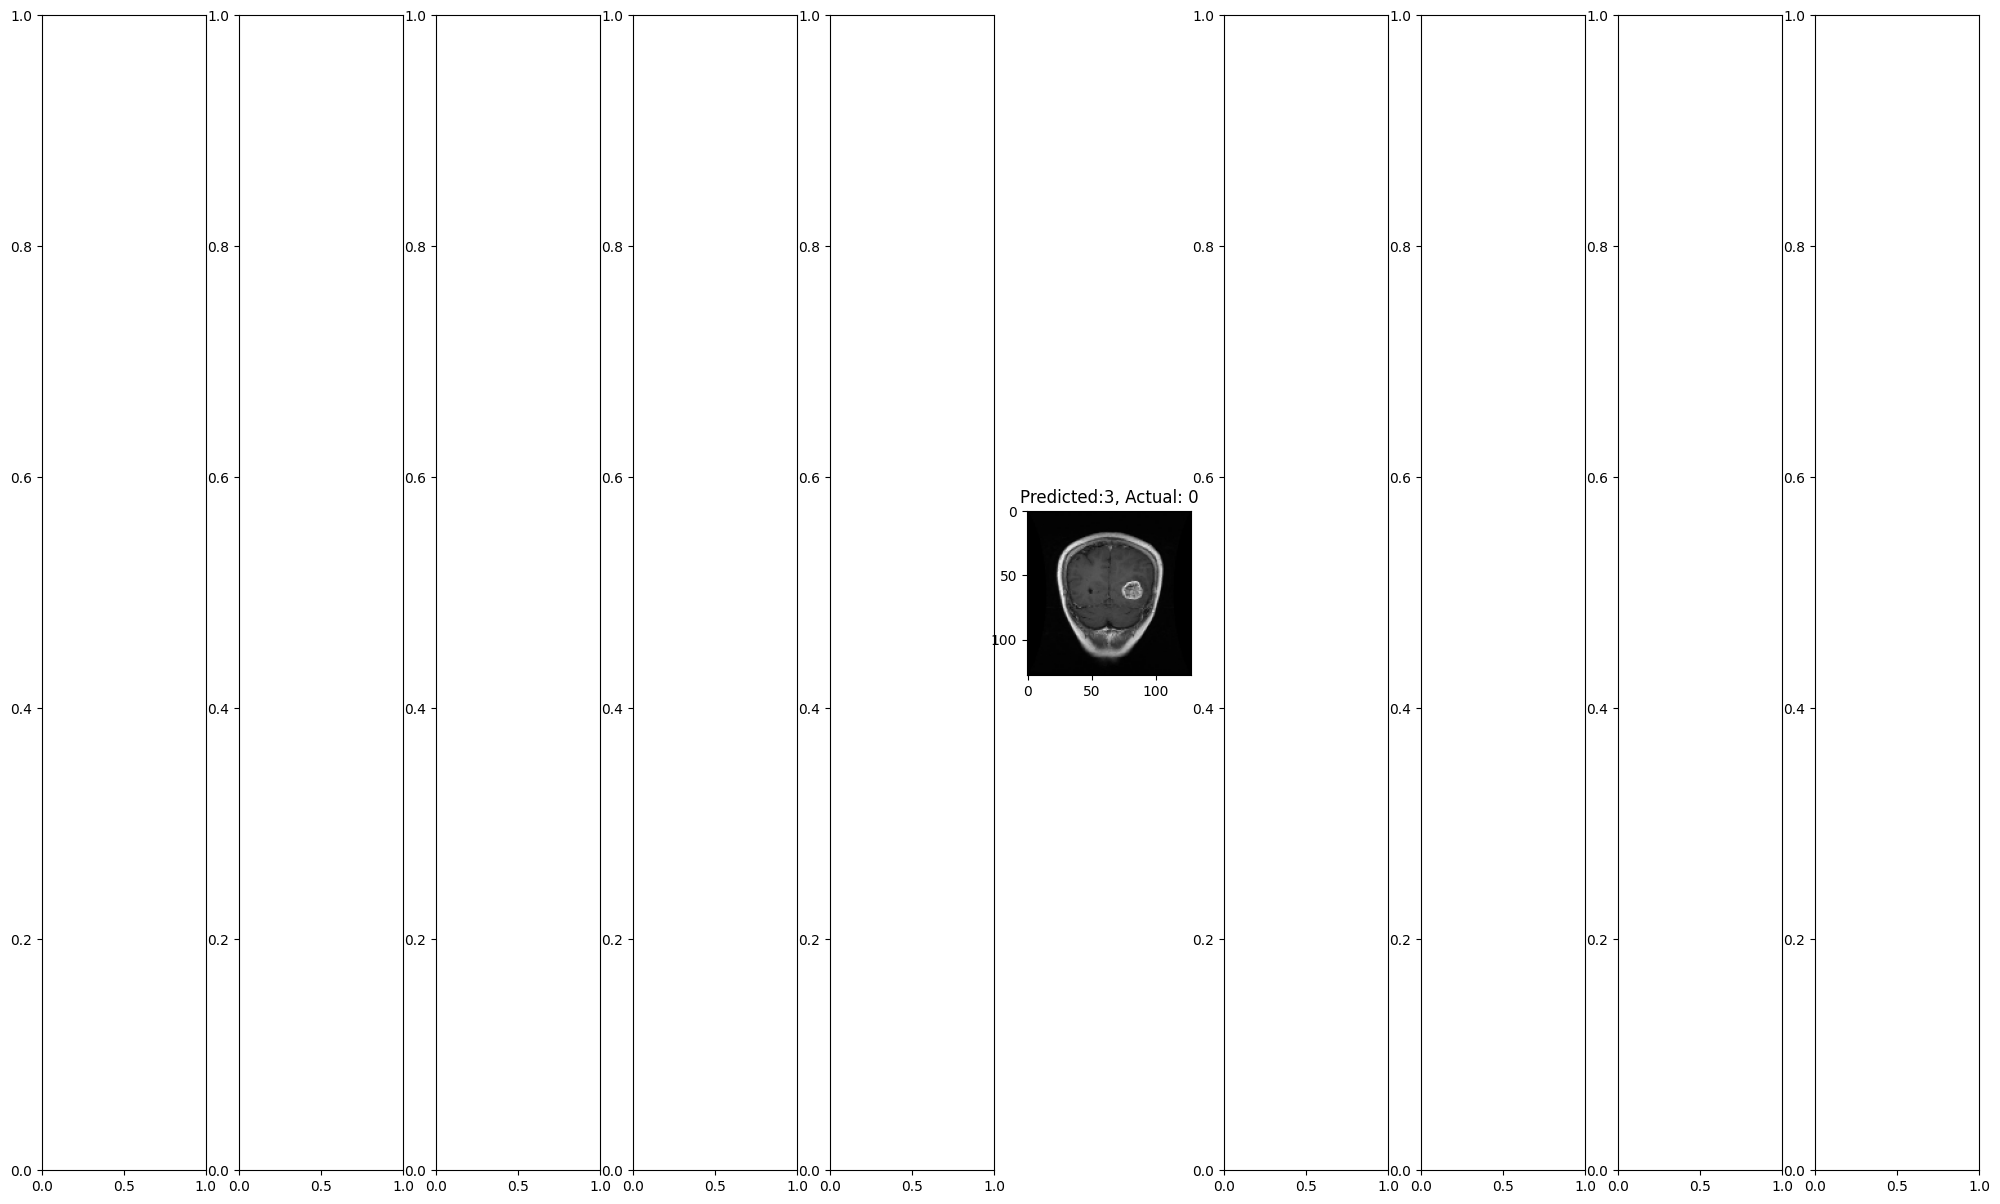

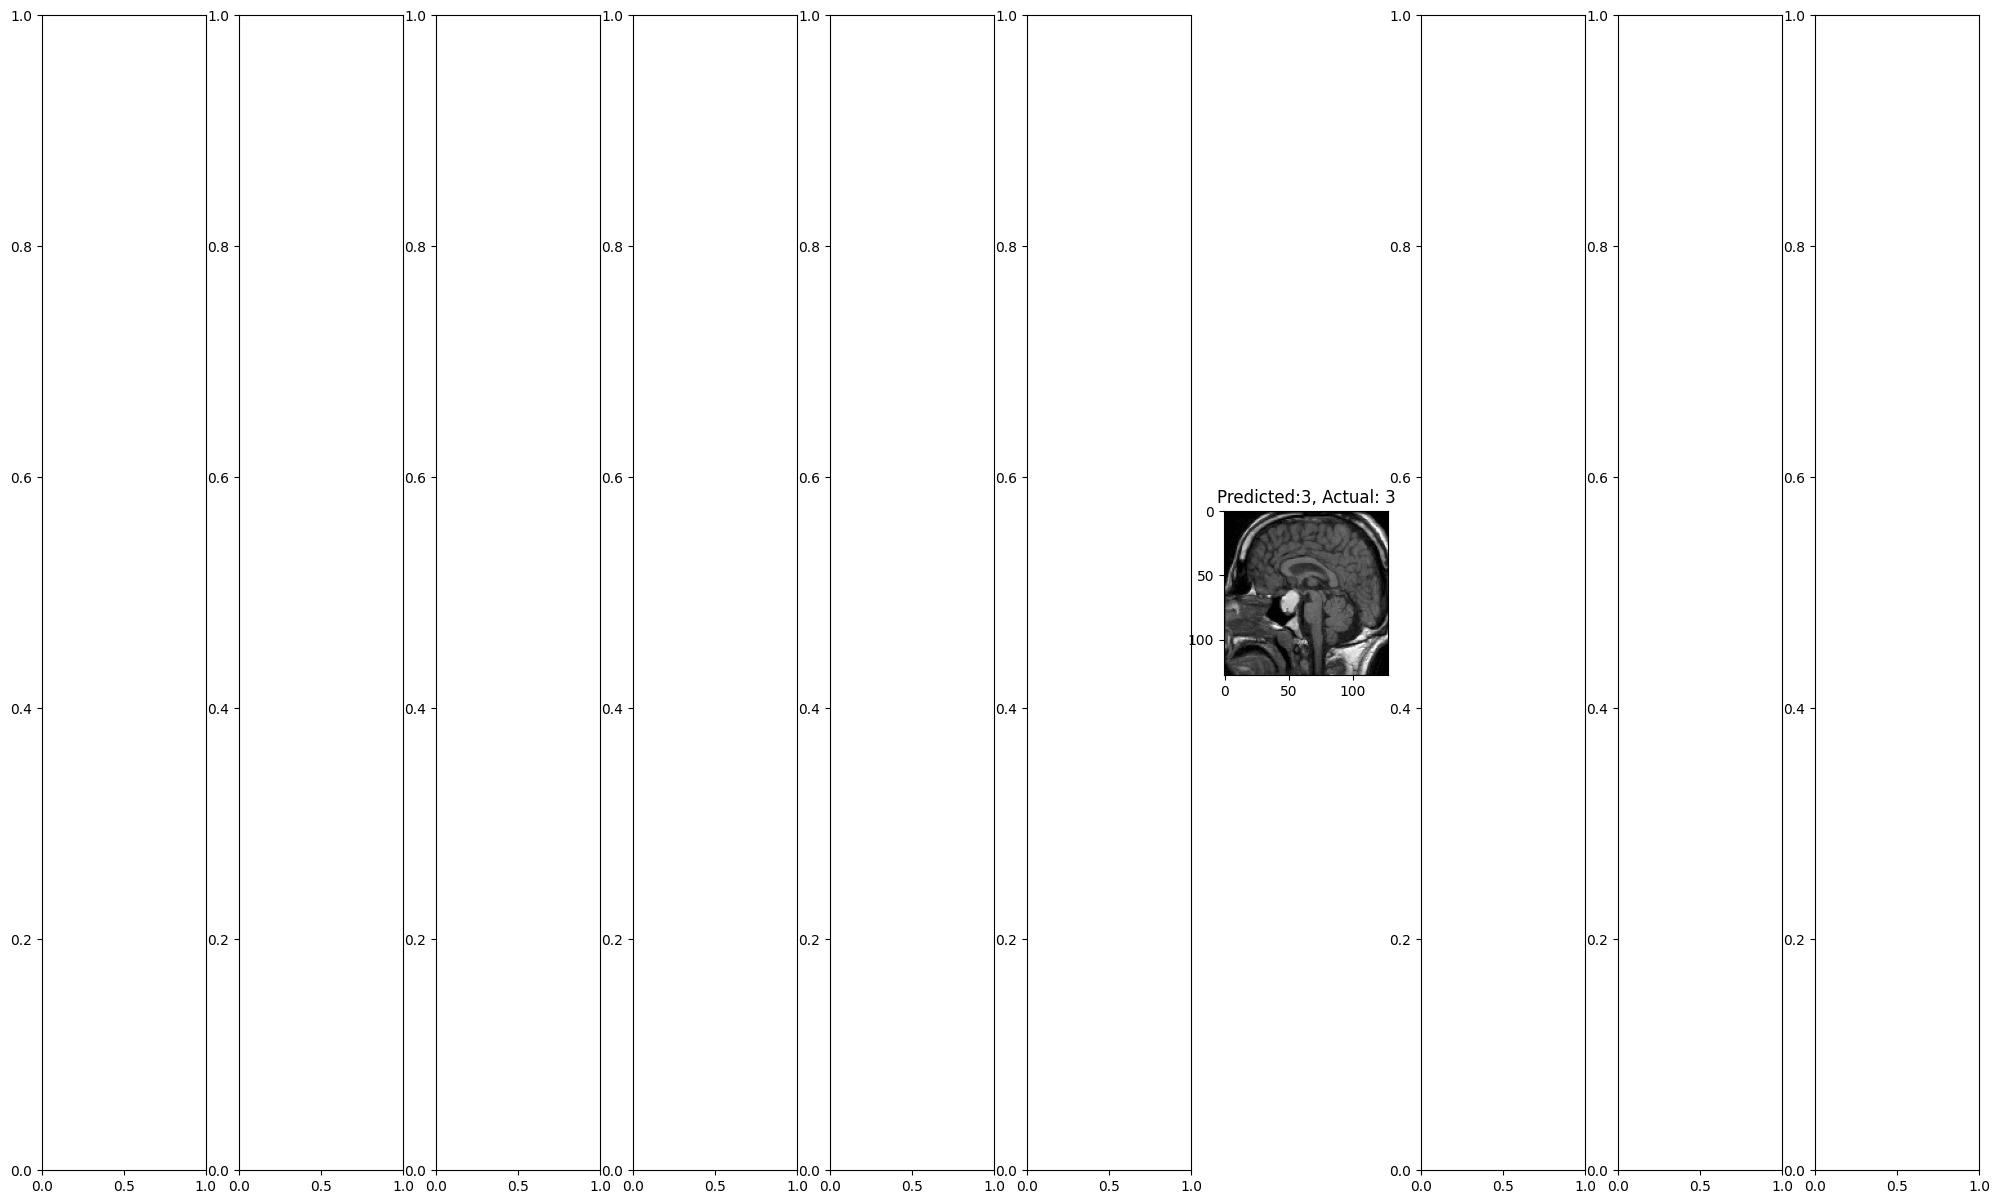

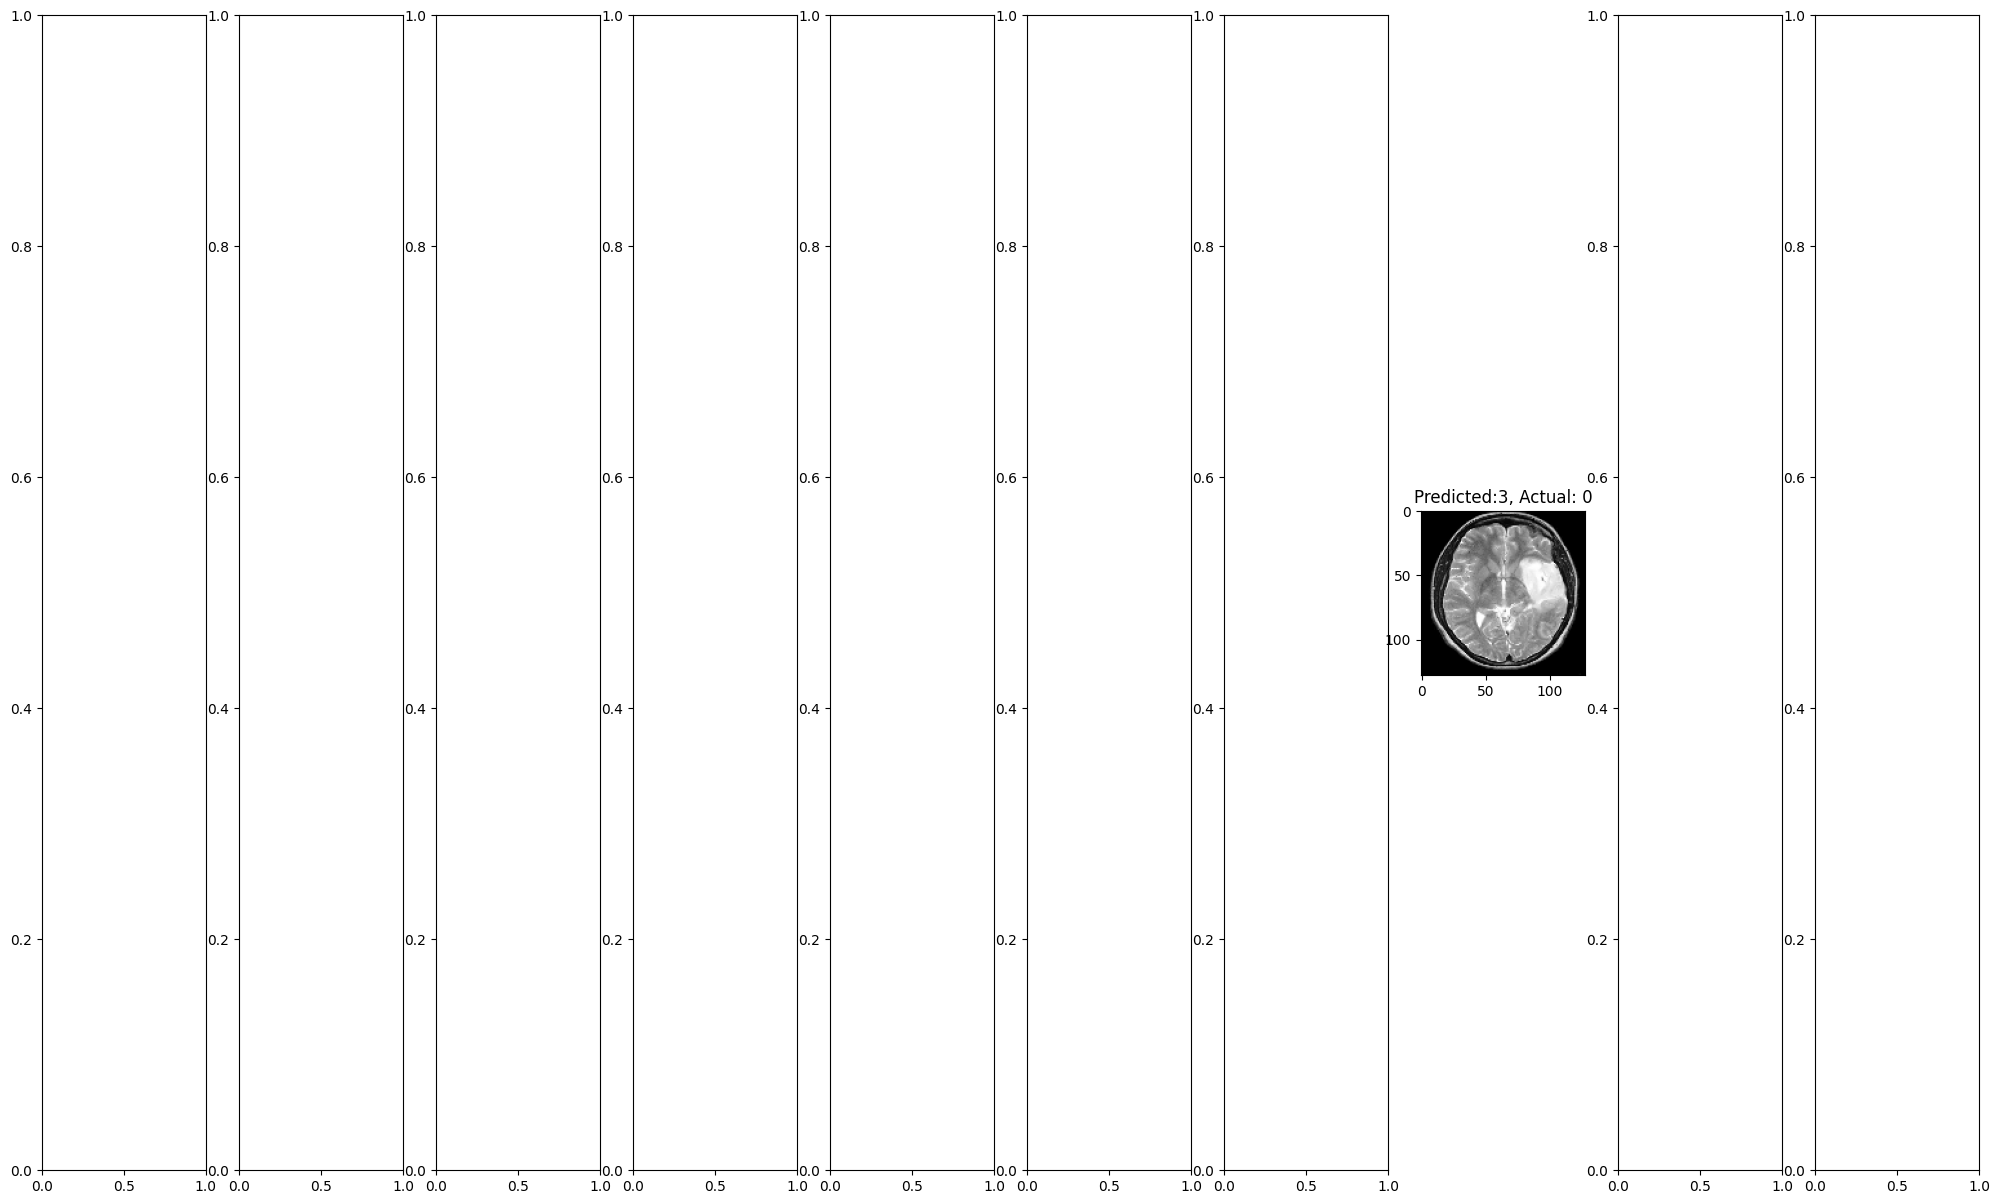

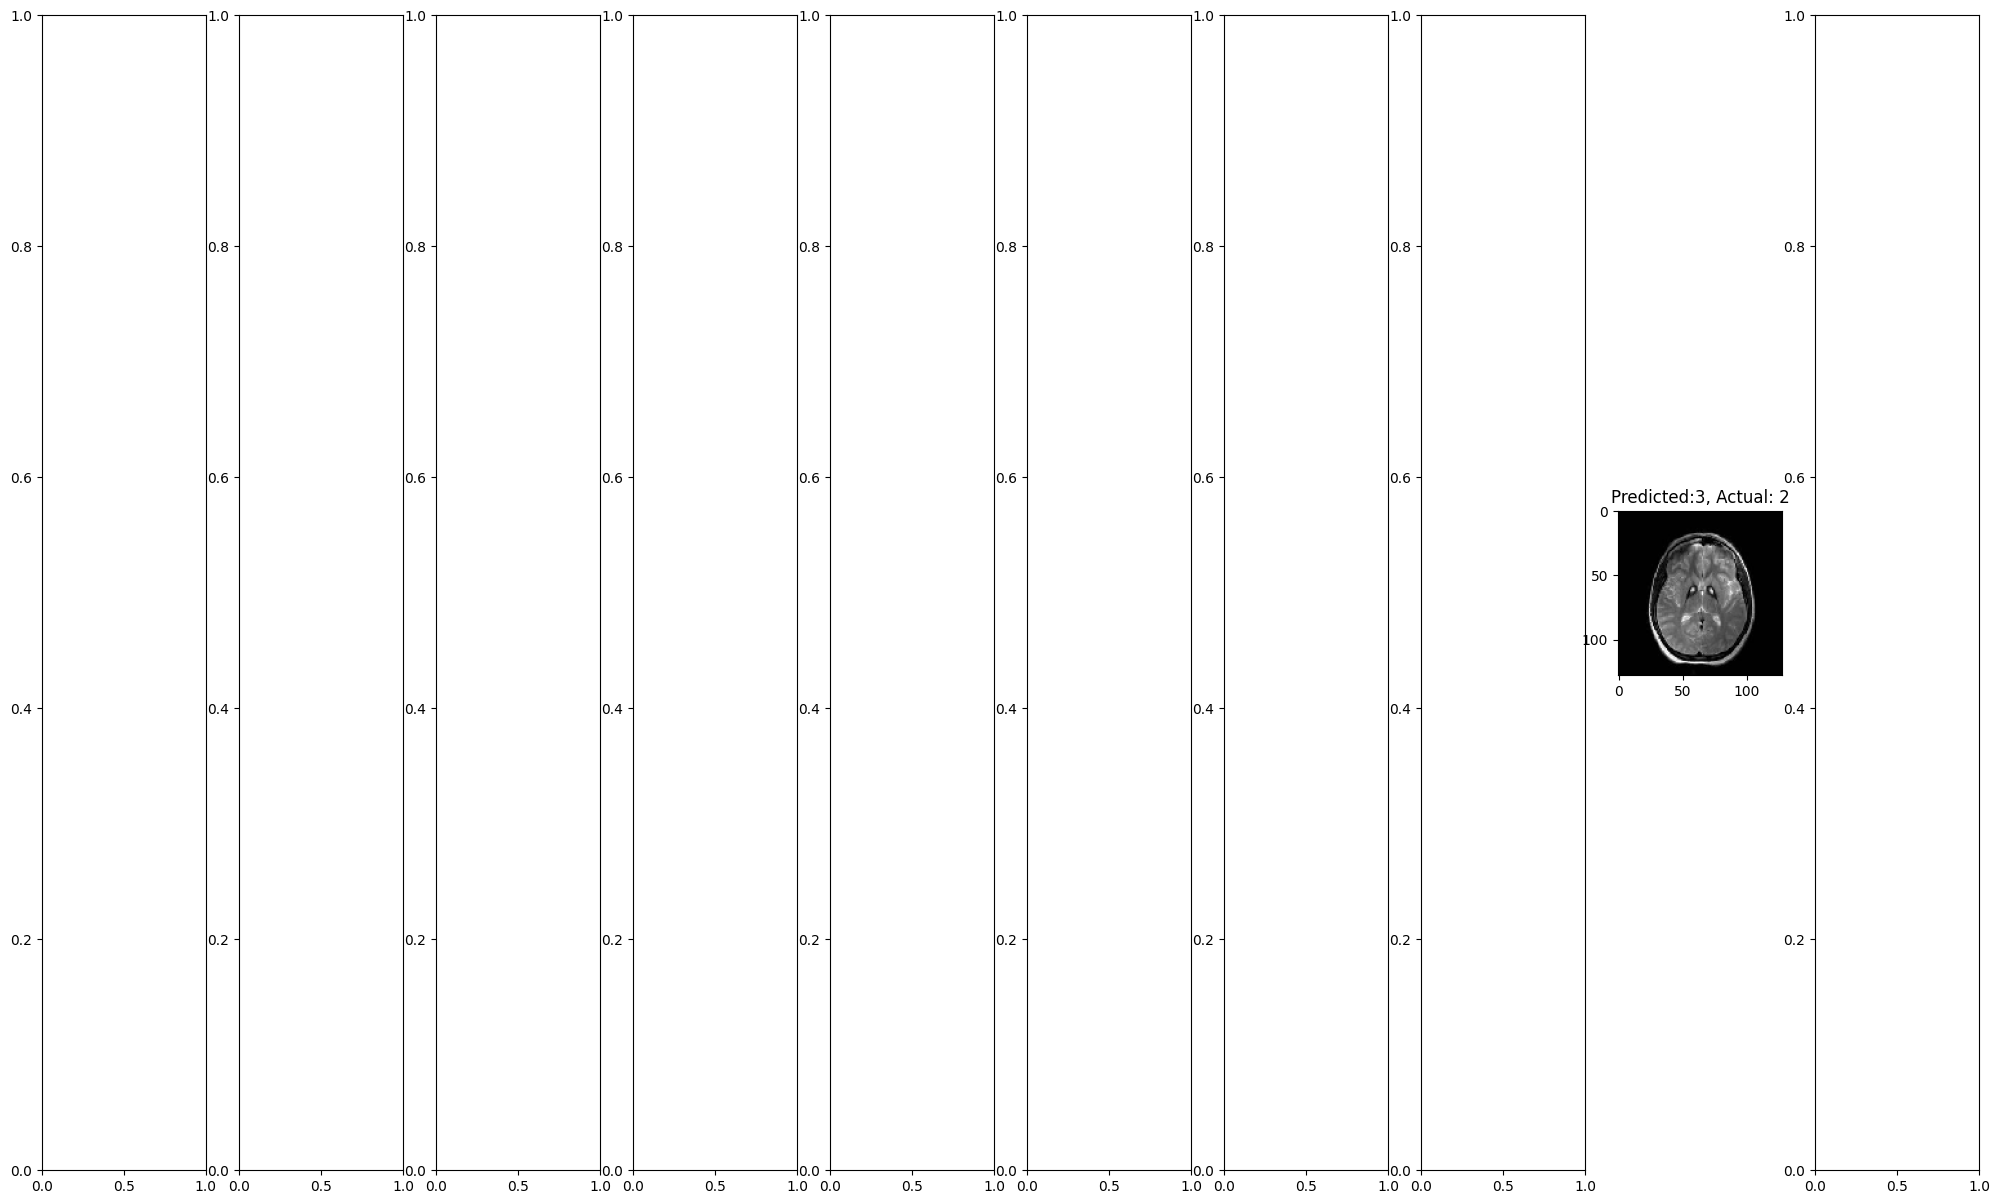

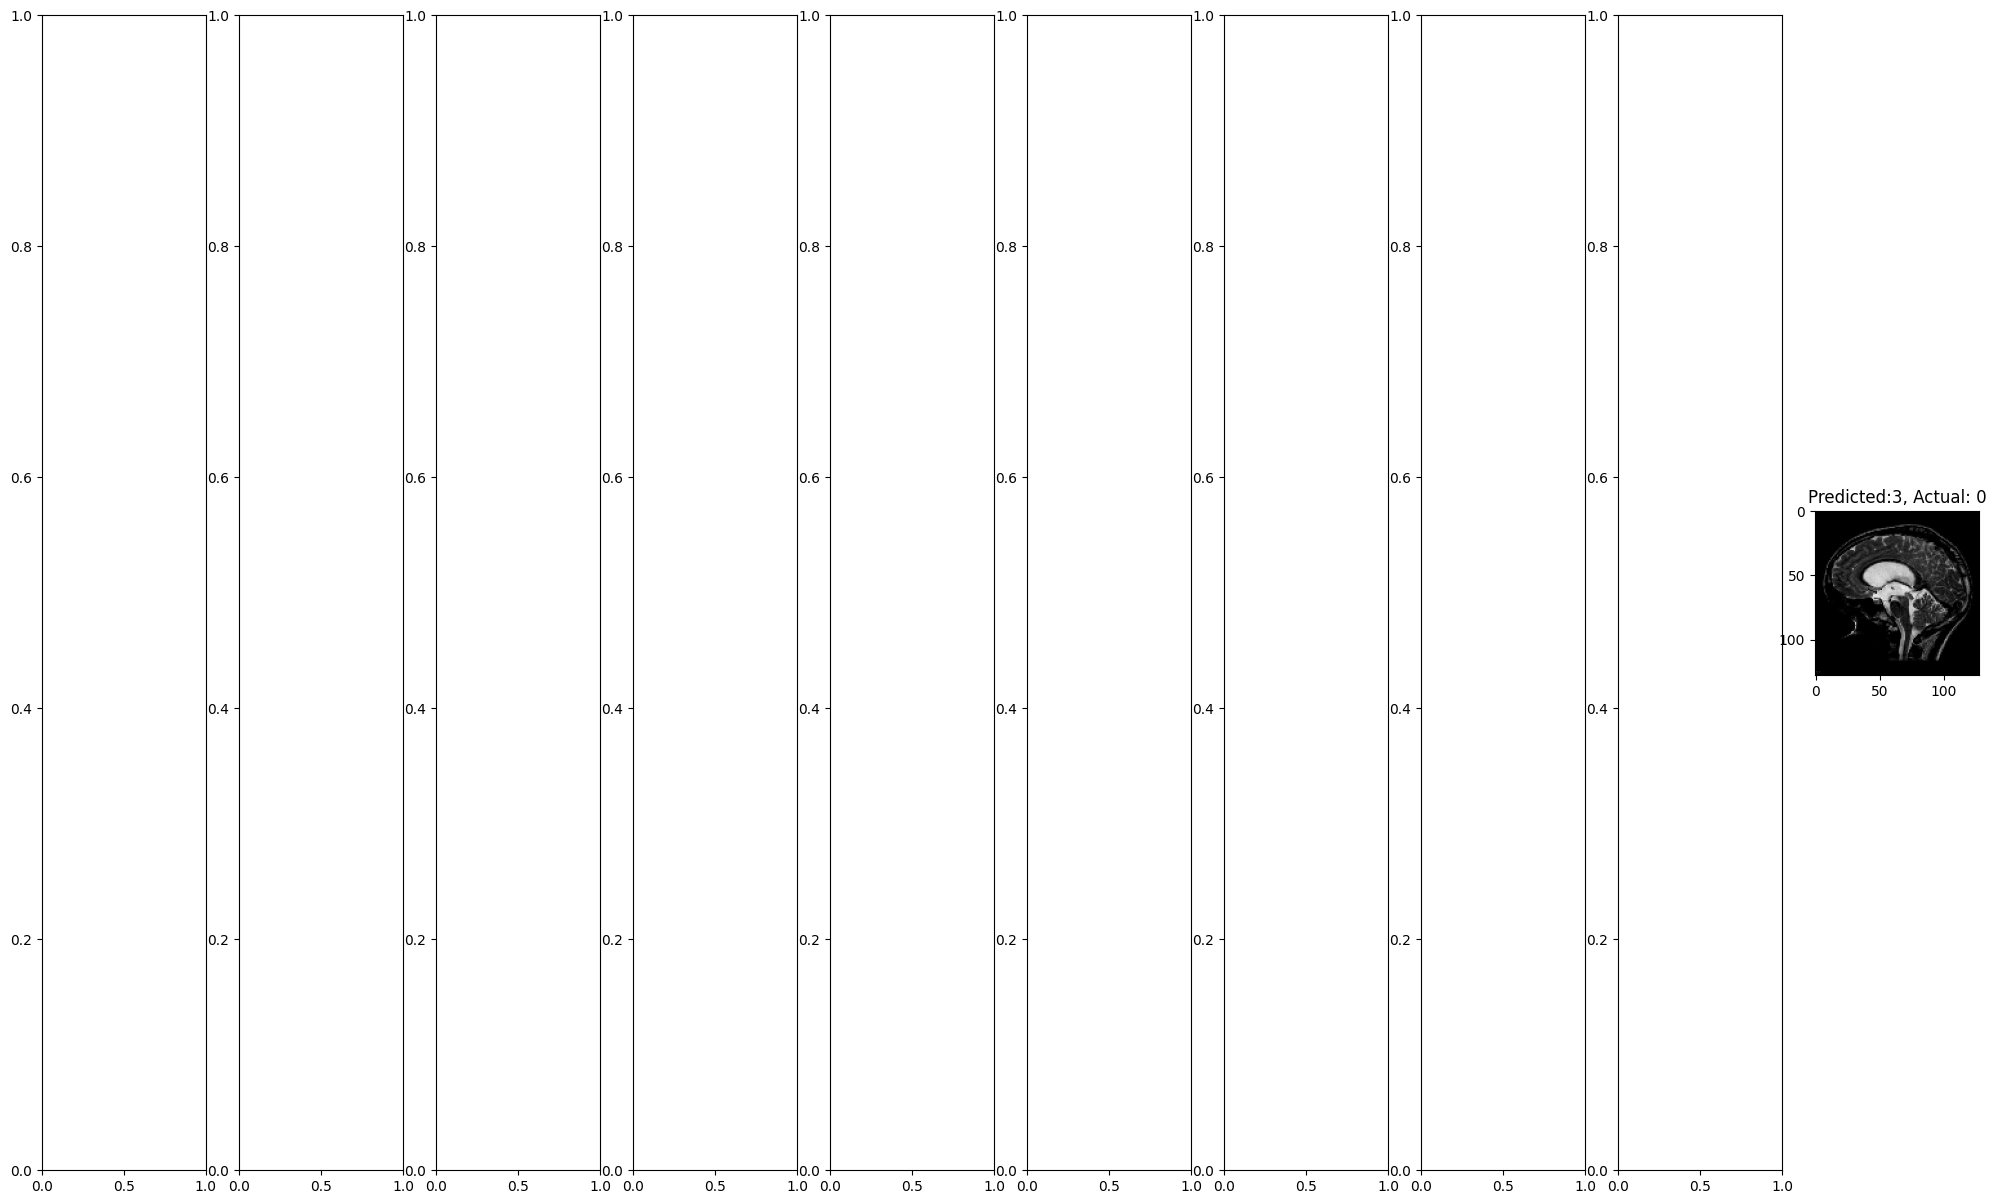

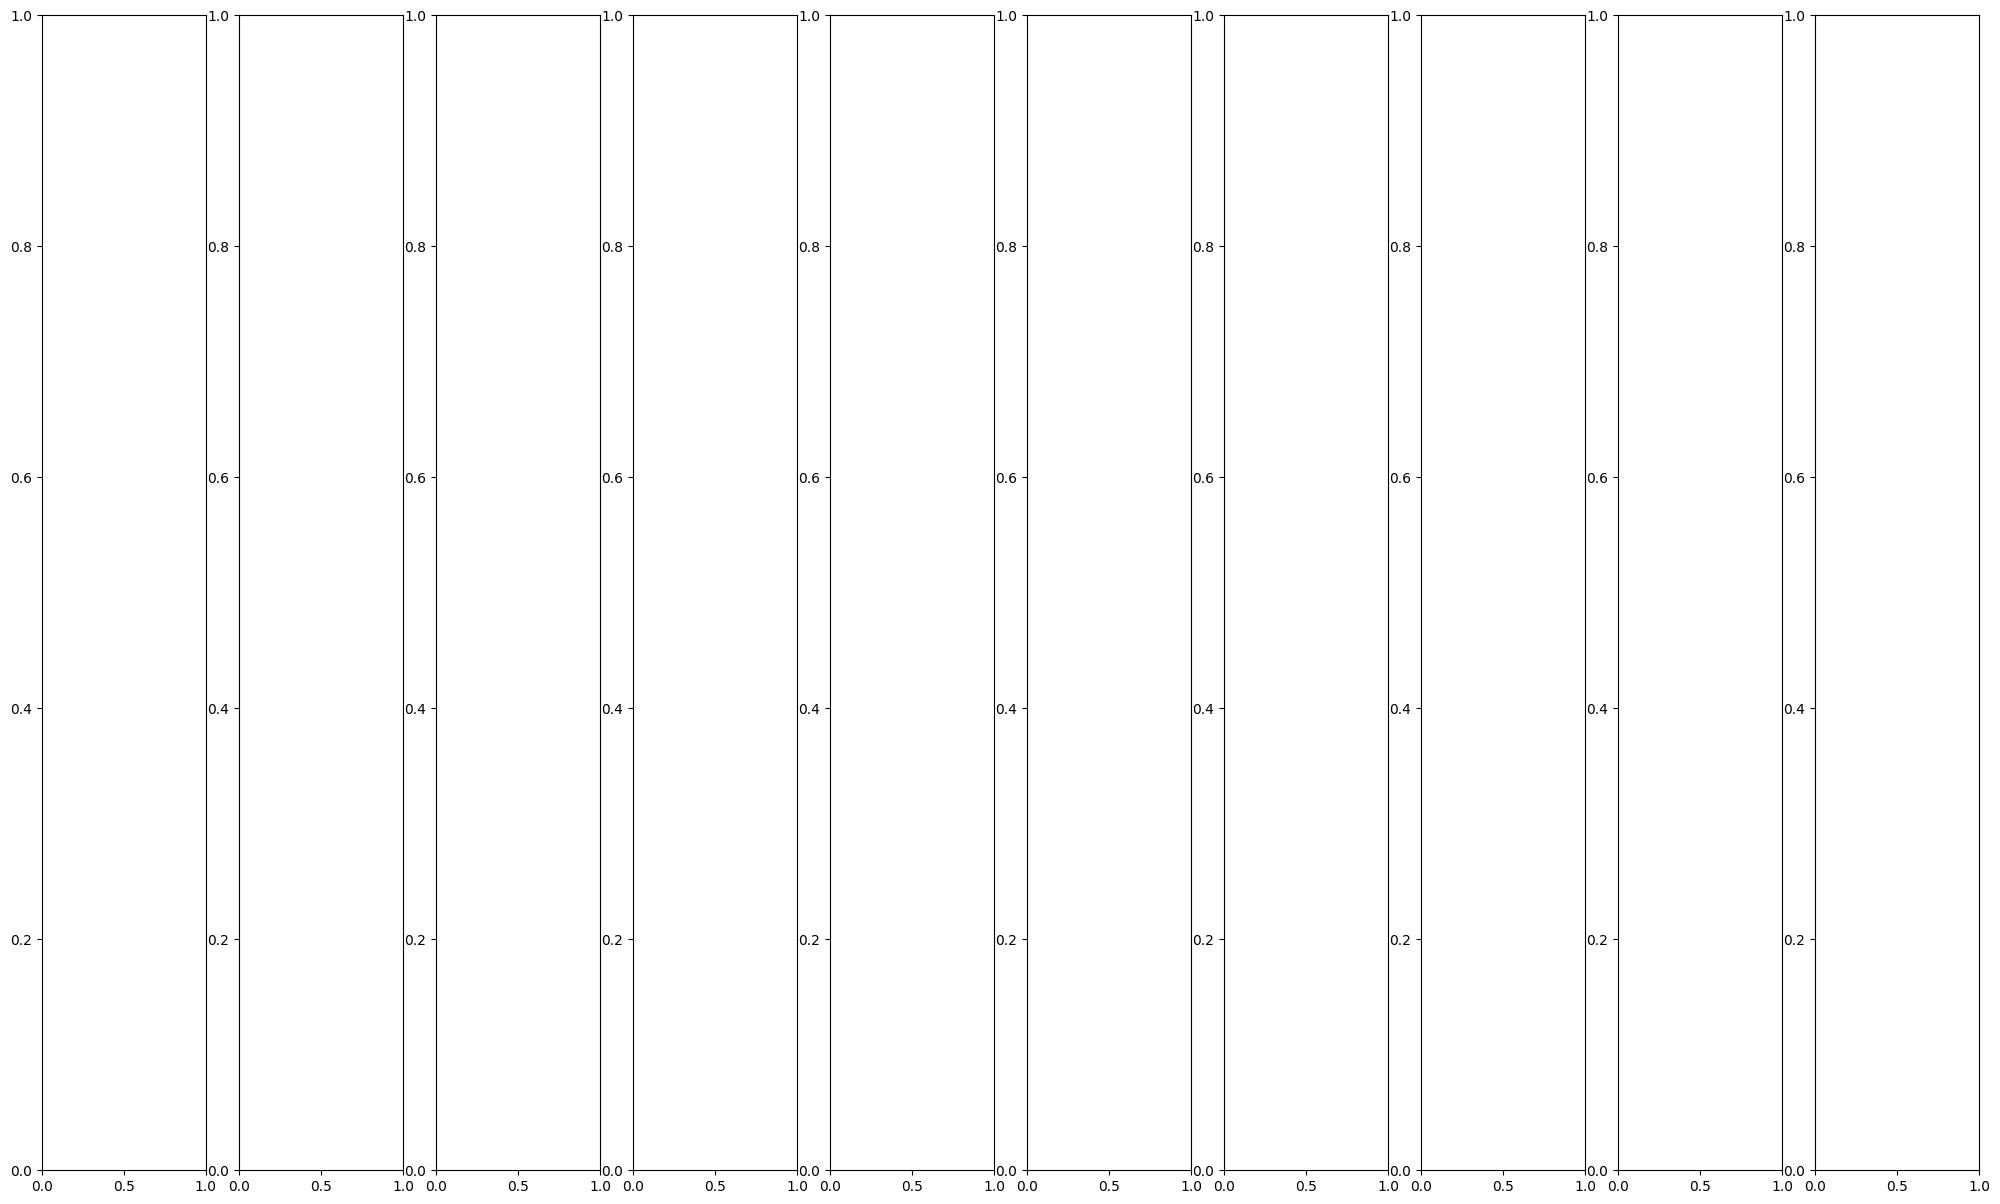

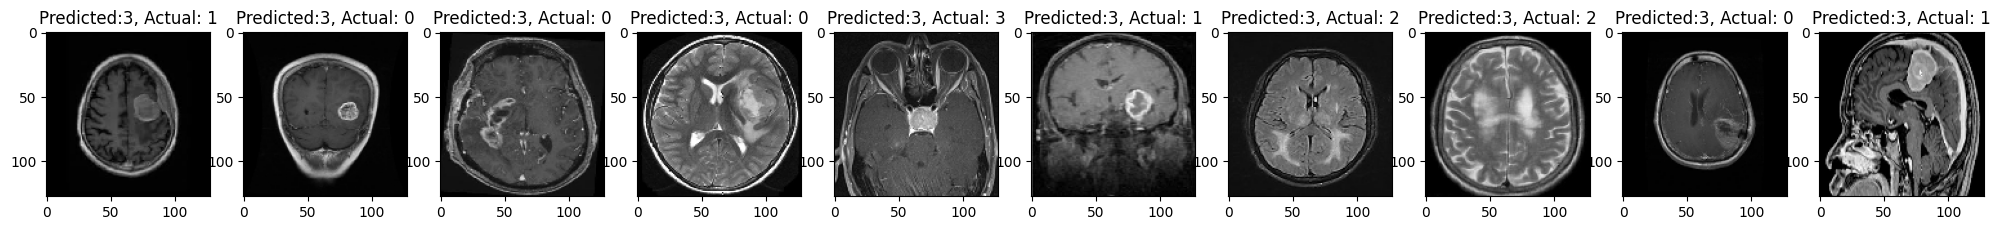

In [38]:
fig,ax = plt.subplots(1,10,figsize = (25,15))
for i in range(10):
    rand_index = np.random.randint(390)
    ax[i].imshow(x_test[rand_index])
    ax[i].set_title(f"Predicted:{prediction[rand_index]}, Actual: {y_test[rand_index]}")
    fig,ax = plt.subplots(1,10,figsize = (25,15))
fig2,ax2 = plt.subplots(1,10,figsize = (25,15))
for i in range(10):
    rand_index = np.random.randint(390)
    ax2[i].imshow(x_test[rand_index])
    ax2[i].set_title(f"Predicted:{prediction[rand_index]}, Actual: {y_test[rand_index]}")

In [ ]:
clf1.save('Model.h5')
clf2.save('Model2.h5')